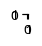

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from src.multimodal_models import BSSVAE, JMVAE
from src.multimodal_train_eval import predict_multimodal
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset



In [2]:
new_df = pd.read_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv')
old_df = pd.read_csv('../data/filtered/240416_nettcr_old_26pep_no_swaps.csv')
new_df_78 = pd.read_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')
new_df_17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
old_df_15 = pd.read_csv('../data/filtered/240416_nettcr_old_top15peps_no_swaps.csv')
old_df_20 = pd.read_csv('../data/filtered/240507_nettcr_old_pruned_noswap_20peps.csv')

In [19]:
tbcr = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0)
tbcr_valid = tbcr.query('partition==0')
tbcr_valid = tbcr_valid[[str(x) for x in tbcr_valid.index]+['peptide','binder','partition','raw_index']]
tbcr_array = tbcr_valid.iloc[:len(tbcr_valid), :len(tbcr_valid)].values

# Check old clustering pruning cnn etc results

In [4]:
get_all_rpauc??

Signature: get_all_rpauc(retentions, purities, input_type=None, name=None)
Docstring: <no docstring>
Source:   
def get_all_rpauc(retentions, purities, input_type=None, name=None):
    total_auc = get_retpur_auc(retentions, purities)
    p60_auc = get_retpur_auc(retentions, purities, min_purity=0.6)
    p70_auc = get_retpur_auc(retentions, purities, min_purity=0.7)

    p60_r40_auc = get_retpur_auc(retentions, purities, min_retention=0.4, min_purity=0.6)
    p70_r35_auc = get_retpur_auc(retentions, purities, min_retention=0.35, min_purity=0.70)
    p70_r50_auc = get_retpur_auc(retentions, purities, min_retention=0.5, min_purity=0.70)
    out = {'input_type': input_type,
           'name': name,
           'total_auc': total_auc,
           'p70_auc': p70_auc,
           'p60_auc': p60_auc,
           'p60_r40_auc': p60_r40_auc,
           'p70_r35_auc': p70_r35_auc,
           'p70_r50_auc': p70_r50_auc}

    return out
File:      ~/Documents/code/tclustr/src/cluster_utils.py
Type:    

In [5]:
test = pd.read_csv('../output/240515_IntervalClustering/ExpData17peps/ExpModel78_ExpData17peps_240418_nettcr_expanded_20binders_17pep_POSONLY_240514_2312_None/ExpModel78_ExpData17peps_240418_nettcr_expanded_20binders_17pep_POSONLY_240514_2312_None_train_results.csv')

In [11]:
test.groupby('input_type').apply(lambda x: get_all_rpauc(x['retention'], x['mean_purity']))

TypeError: <lambda>() got an unexpected keyword argument 'axis'

In [59]:
from src.cluster_utils import get_all_rpauc
from joblib import Parallel, delayed

def rpauc_wrapper(df, input_type):
    tmp = df.query('input_type==@input_type')
    ret = tmp['retention'].values[1:-1]
    pur = tmp['mean_purity'].values[1:-1]
    return get_all_rpauc(ret, pur, input_type, None)
    
def find_best_not_agg(intervals):
    tmp = intervals.query('not input_type.str.contains("TBCR") and not input_type.str.startswith("agg") and not input_type.str.contains("tcrdist")')
    results = pd.DataFrame(Parallel(n_jobs=5)(delayed(rpauc_wrapper)(df=tmp, input_type=k) for k in tmp.input_type.unique()))
    best=results.sort_values('p70_r35_auc', ascending=False).head(1).input_type.item()
    return tmp.query('input_type==@best')

def find_agg(fn):
    return pd.read_csv(fn).query('input_type.str.startswith("agg")')


def get_agg_given_dir(maindir, set, idf):
    folders = glob.glob(f'{maindir}/*/*{set}*.csv')
    baselines = pd.read_csv(folders[0]).query('input_type.str.contains("TBCR") or input_type.str.contains("tcrdist")')
    return pd.concat([baselines] + [find_agg(x) for x in folders]).assign(identifier=idf)
    
def get_best_given_dir(maindir, set, idf):
    folders = glob.glob(f'{maindir}/*/*{set}*.csv')
    baselines = pd.read_csv(folders[0]).query('input_type.str.contains("TBCR") or input_type.str.contains("tcrdist")')
    return pd.concat([baselines] + [find_best_not_agg(pd.read_csv(x)) for x in folders]).assign(identifier=idf)

In [50]:
'ExpModelFull_ExpDataTop78_poch_10000'.split('_ExpDataTop78_')[0]

'ExpModelFull'

In [45]:
glob.glob('../output/240515_IntervalClustering/*')

['../output/240515_IntervalClustering/OldDataTop15',
 '../output/240515_IntervalClustering/ExpDataTop78',
 '../output/240515_IntervalClustering/figs',
 '../output/240515_IntervalClustering/OldDataTop20',
 '../output/240515_IntervalClustering/OldDataNoPrune',
 '../output/240515_IntervalClustering/valid_baselines.csv',
 '../output/240515_IntervalClustering/train_baselines.csv',
 '../output/240515_IntervalClustering/ExpData17peps']

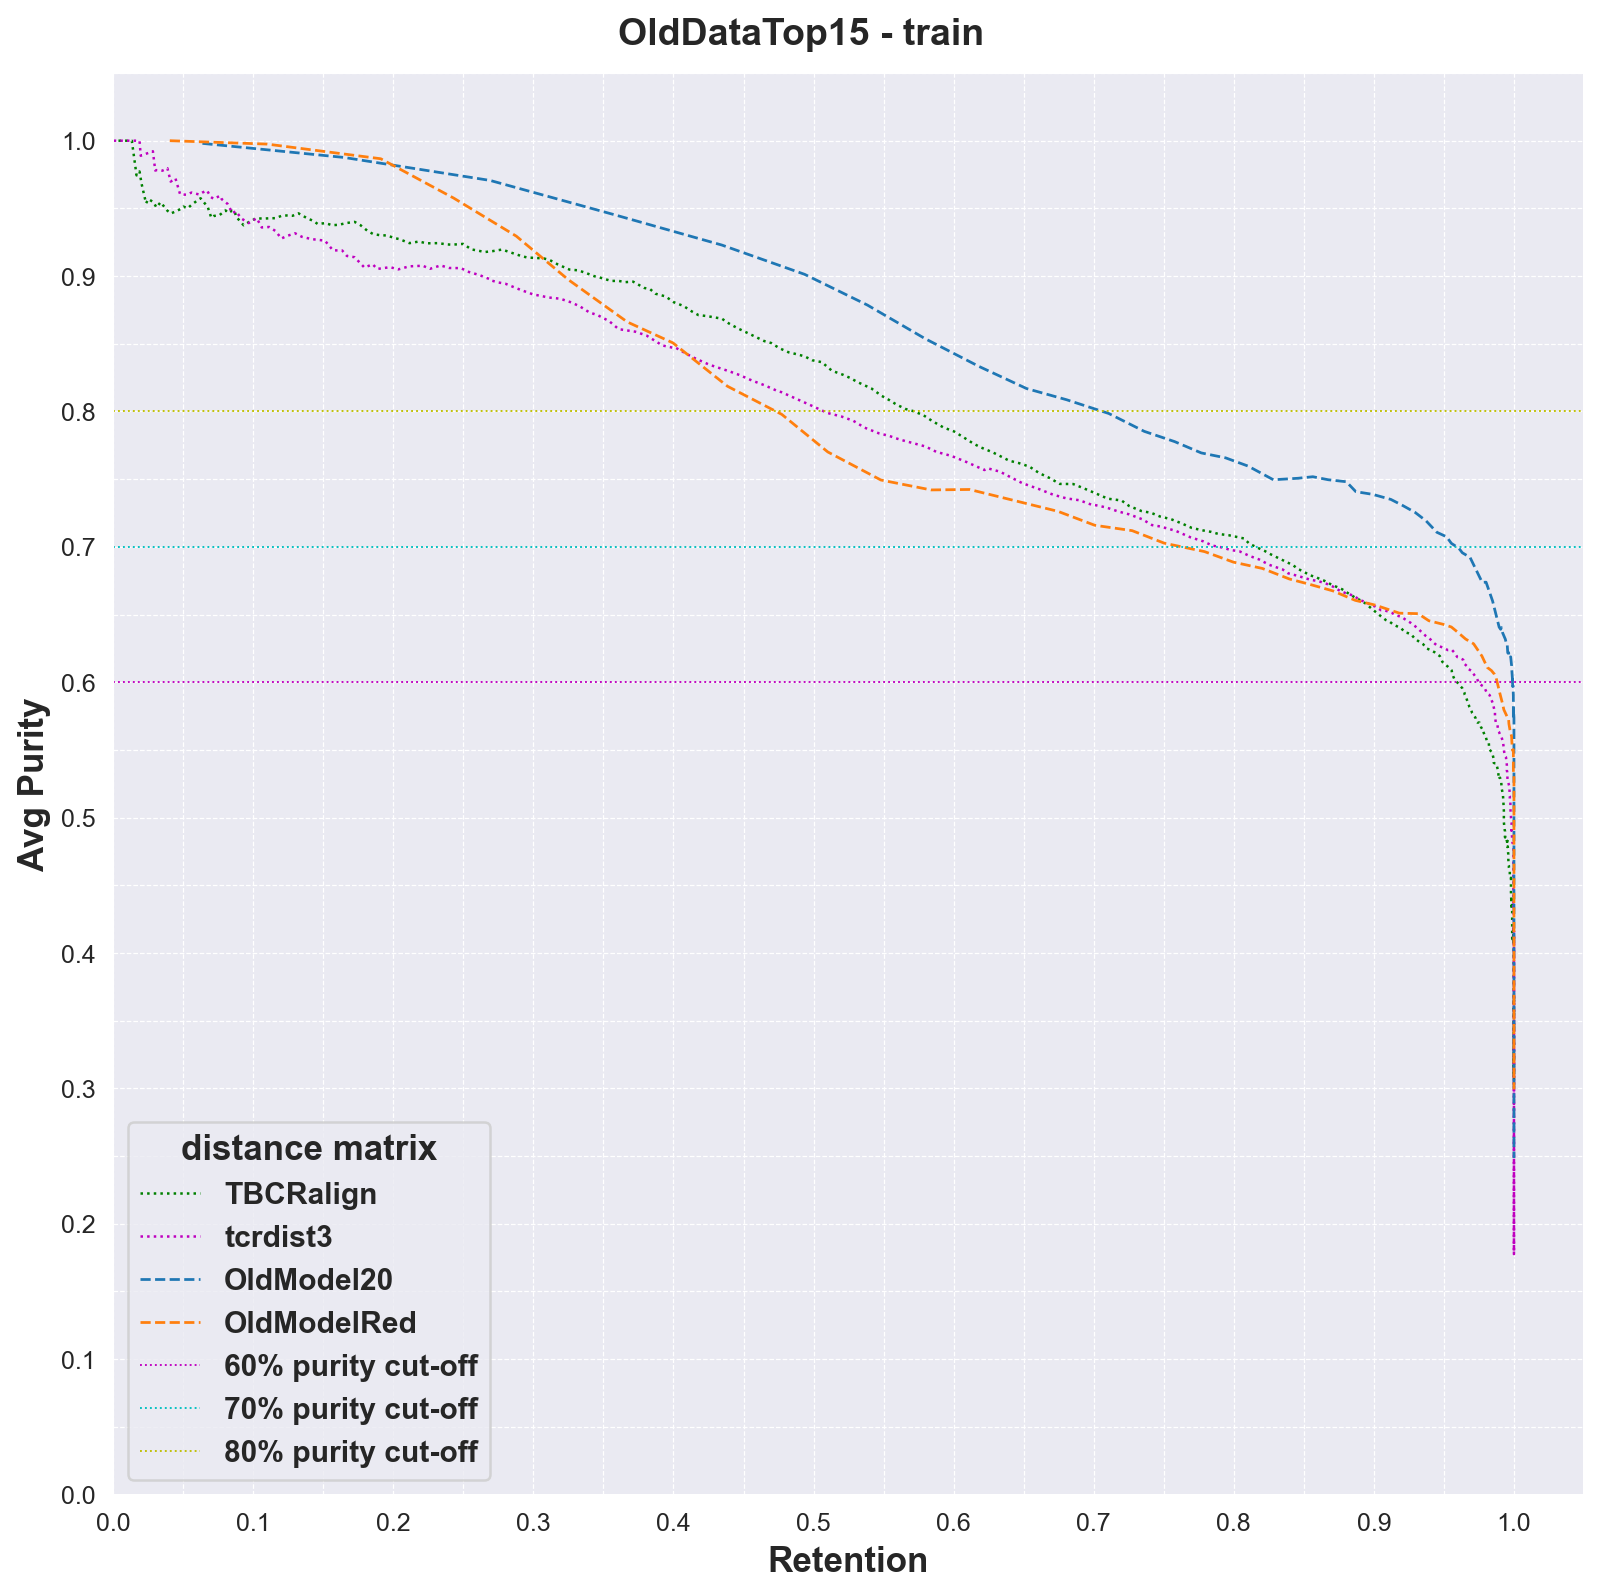

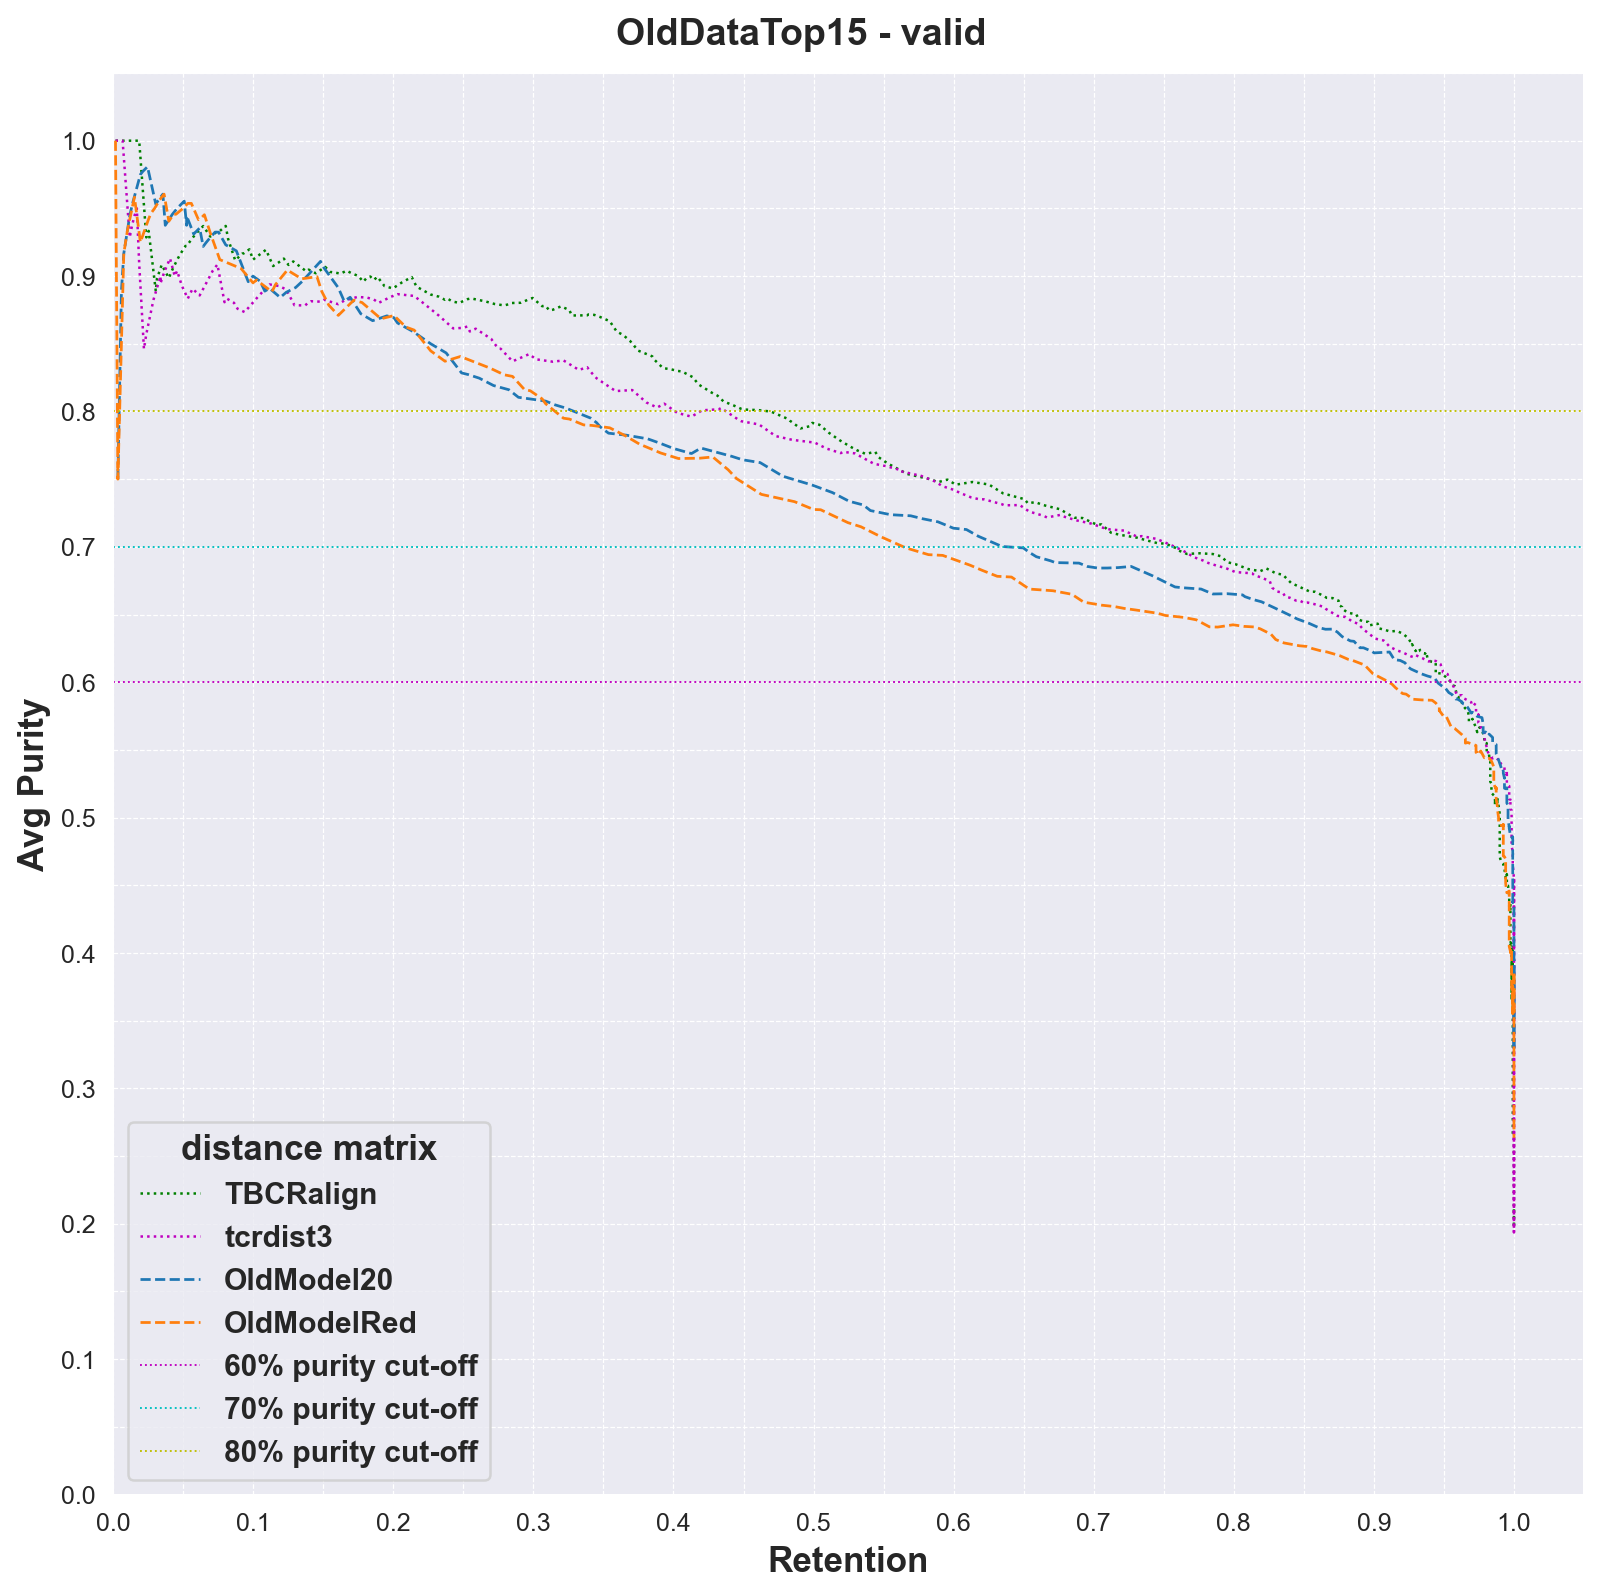

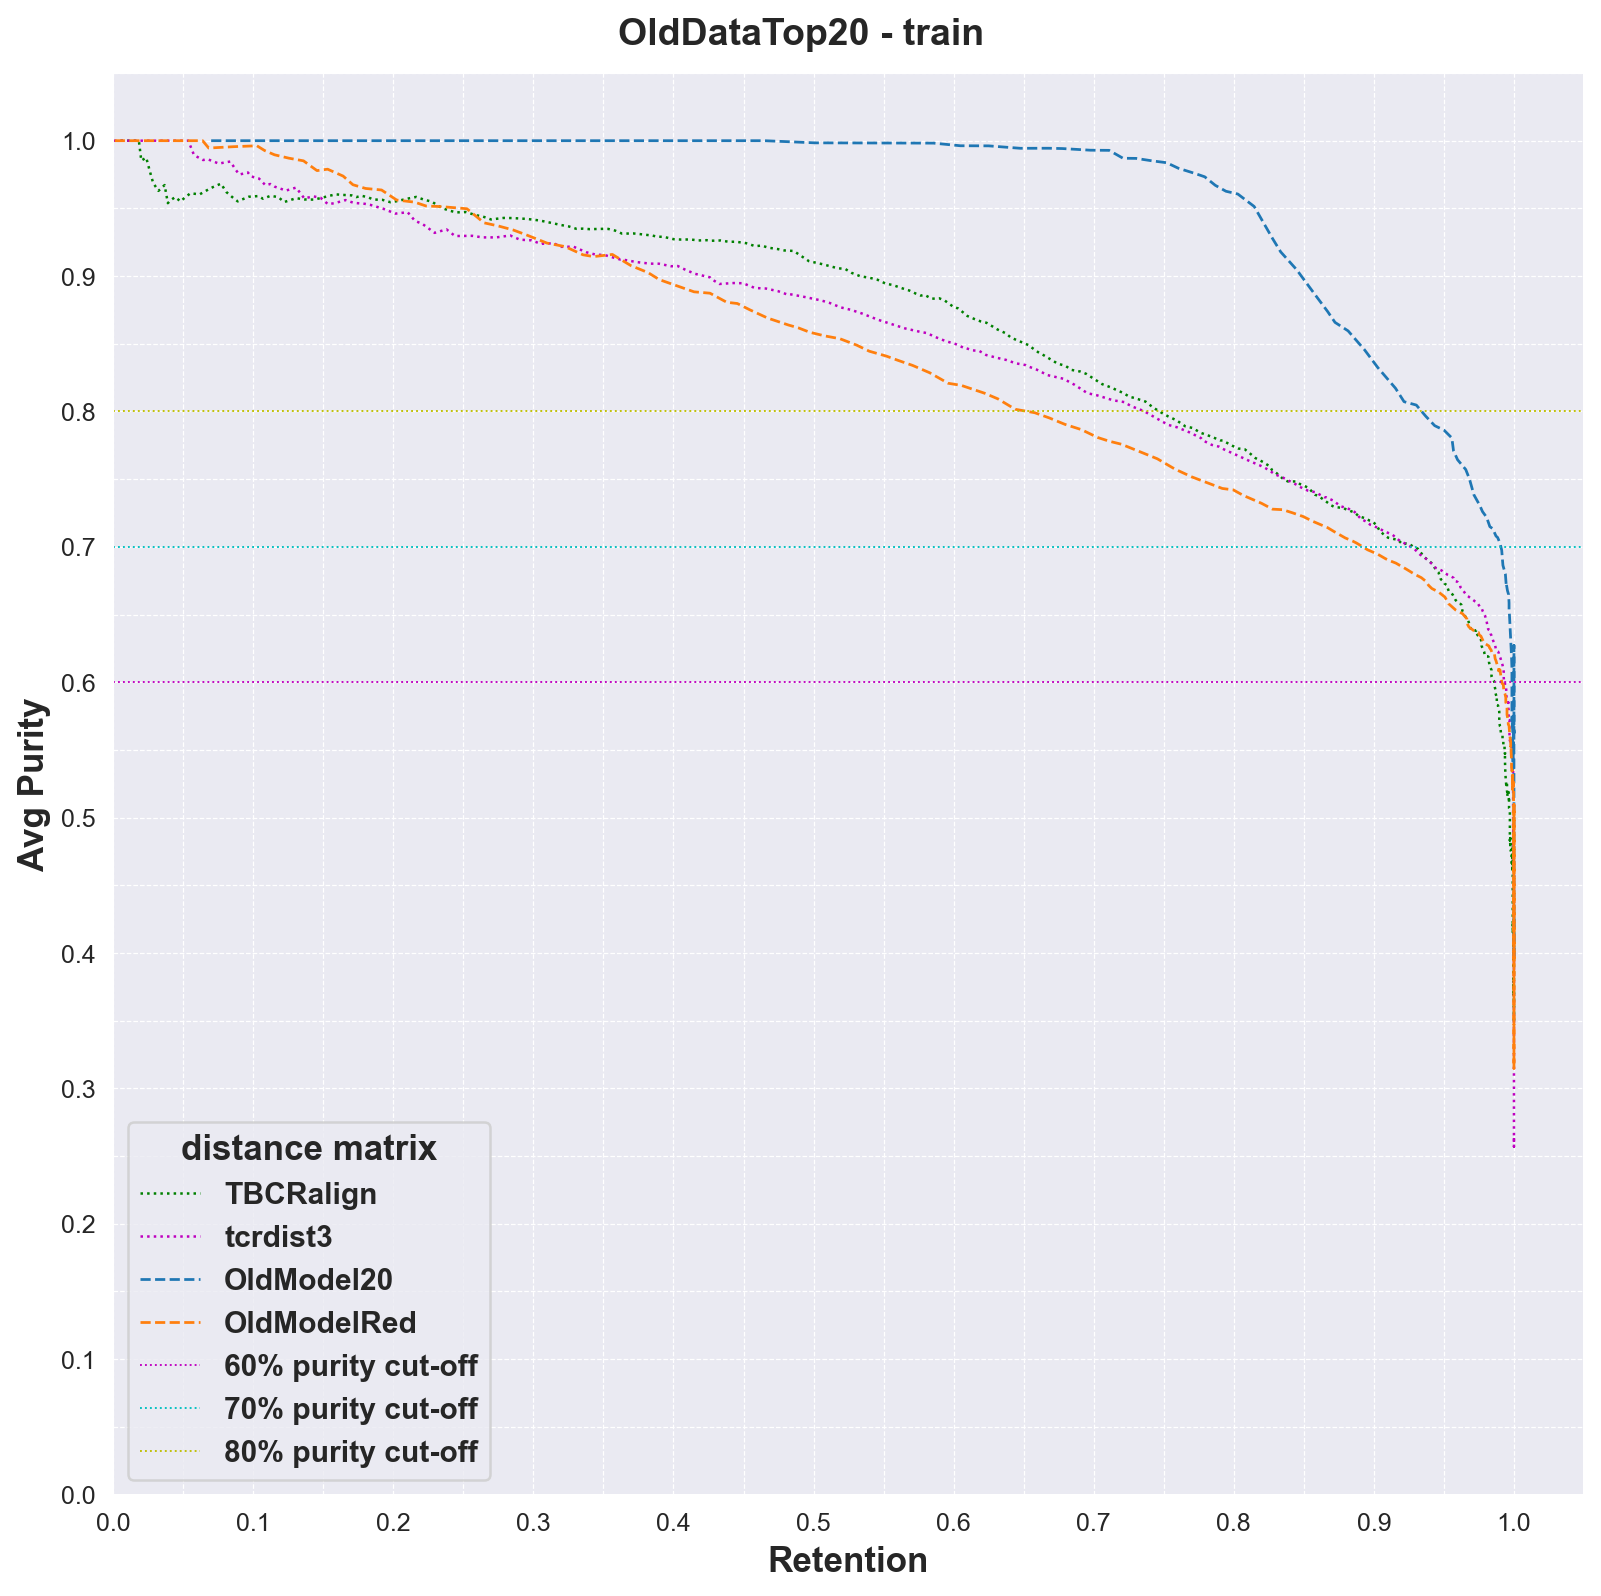

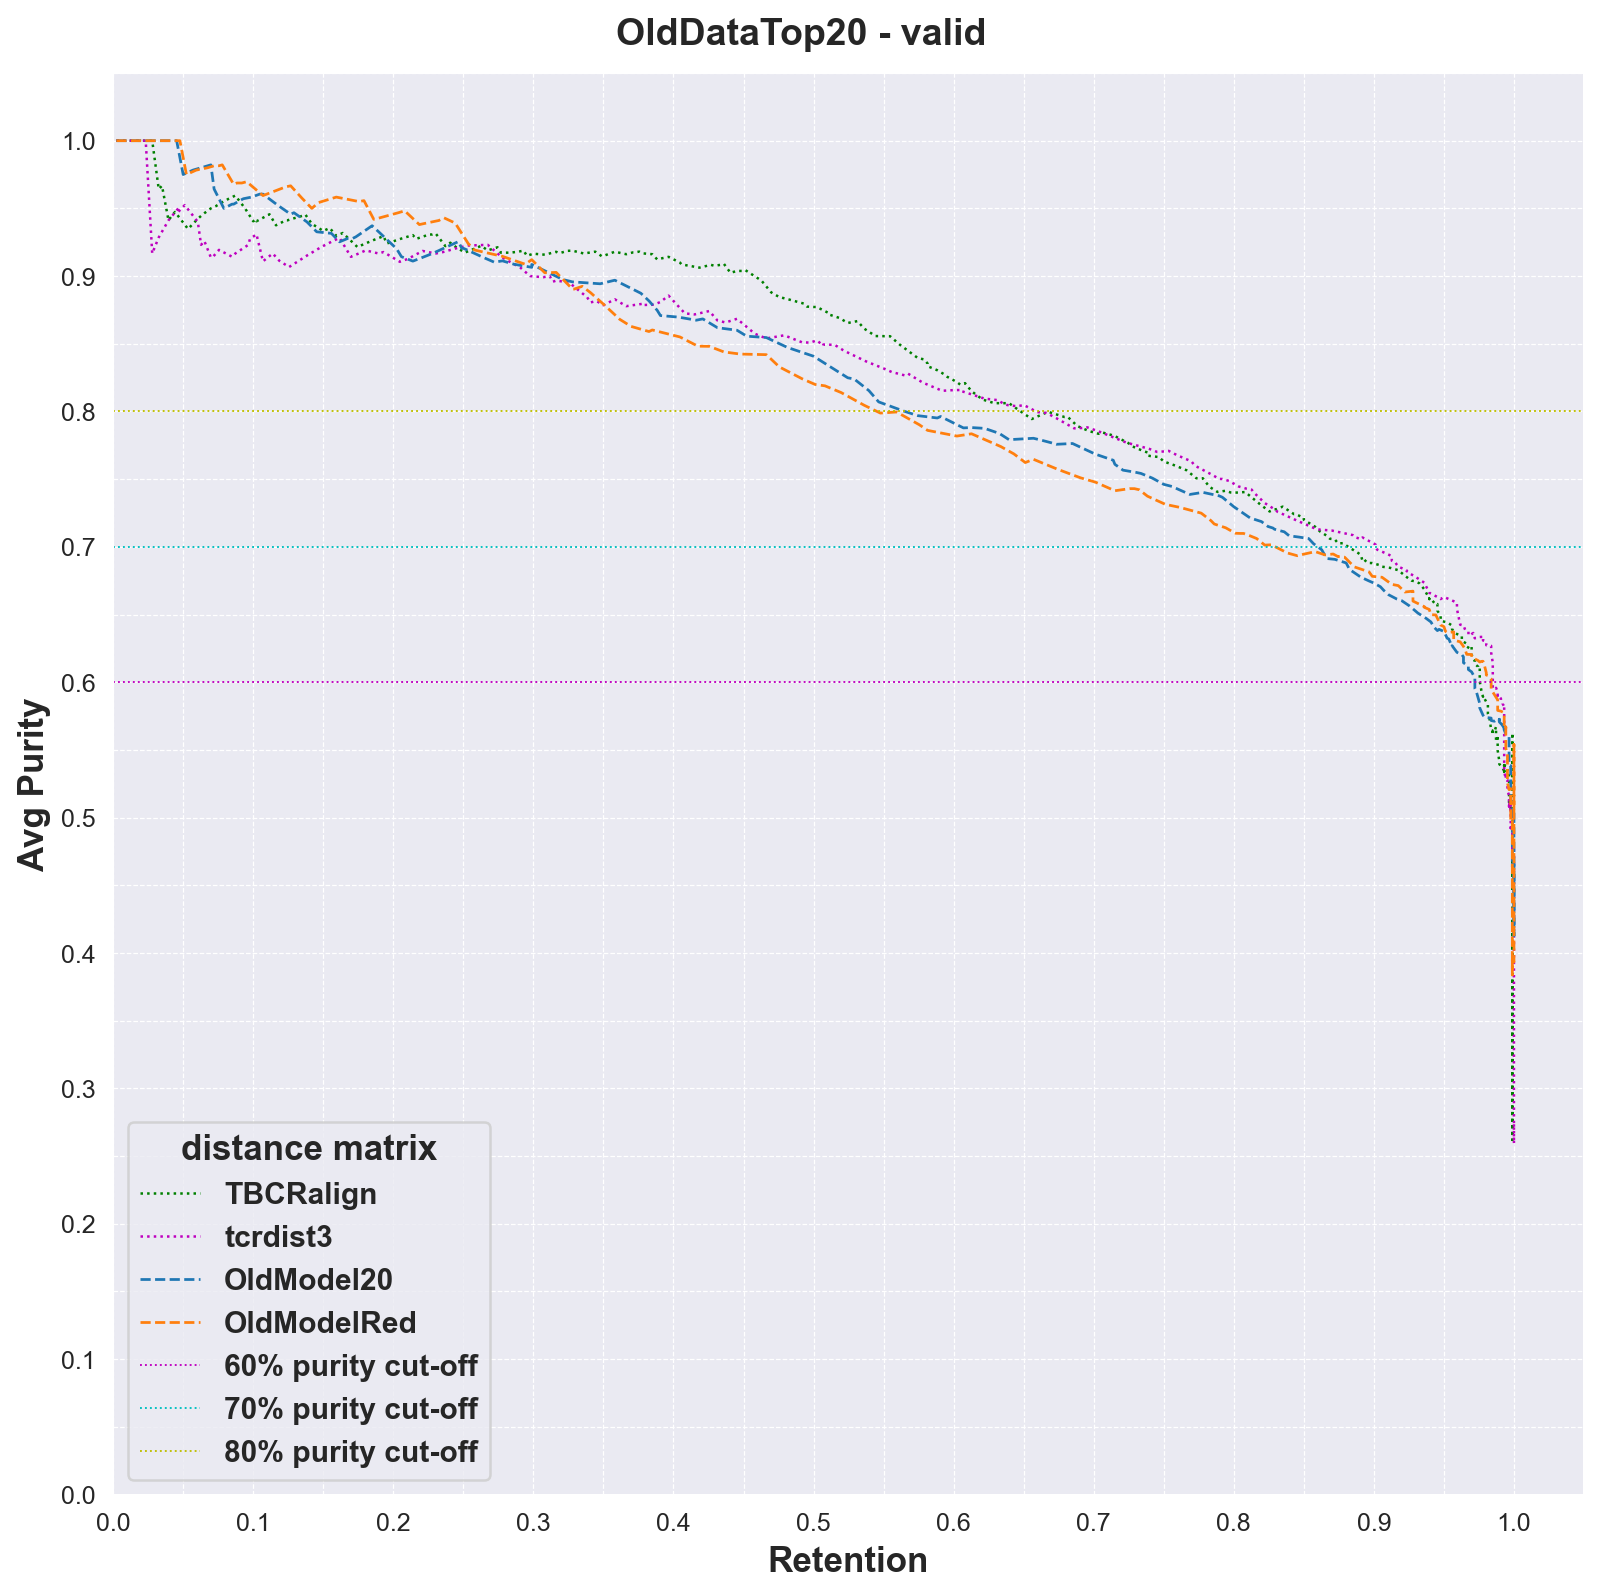

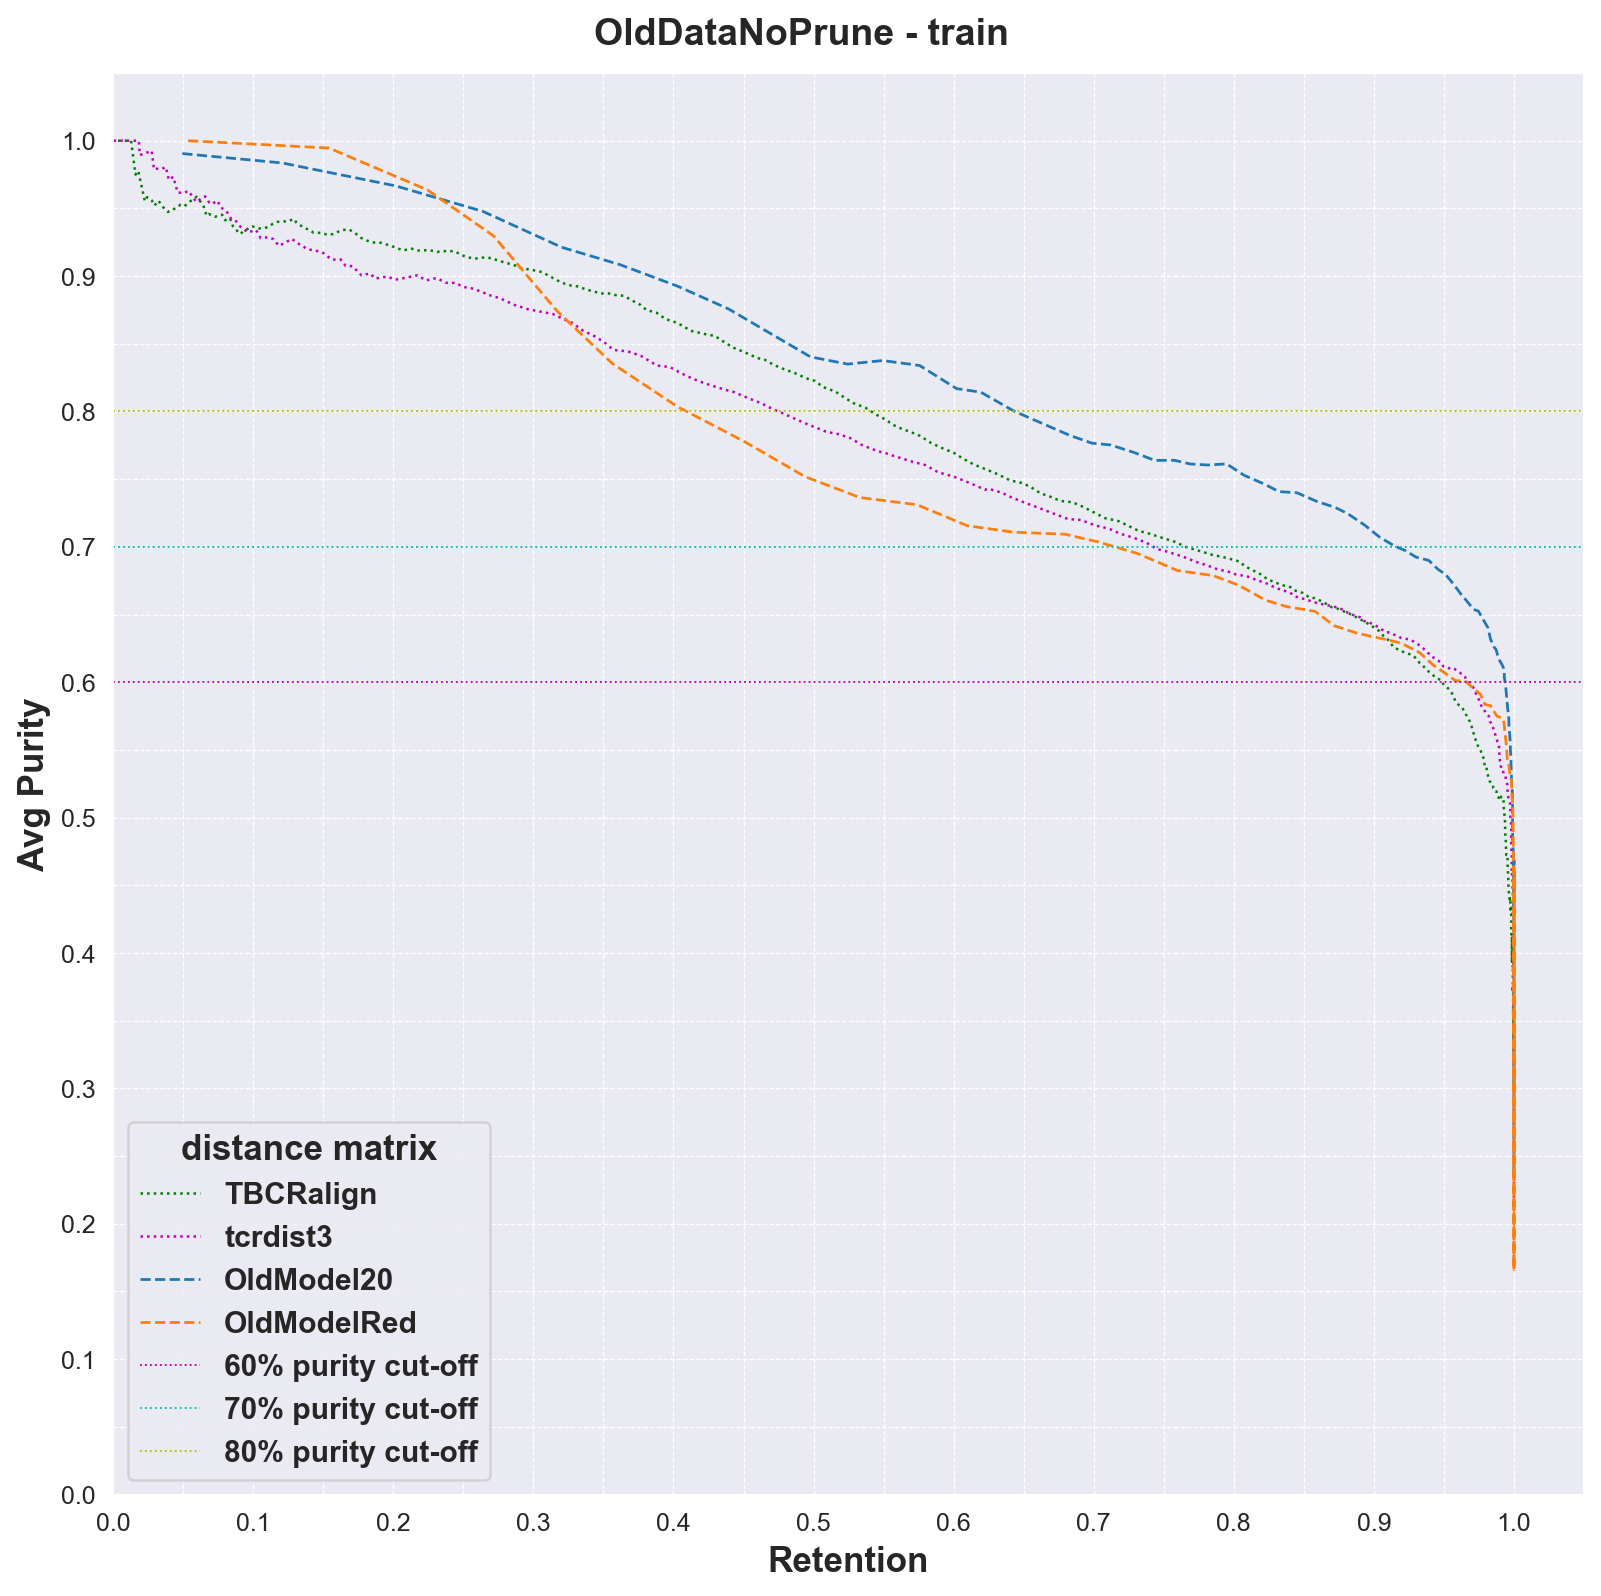

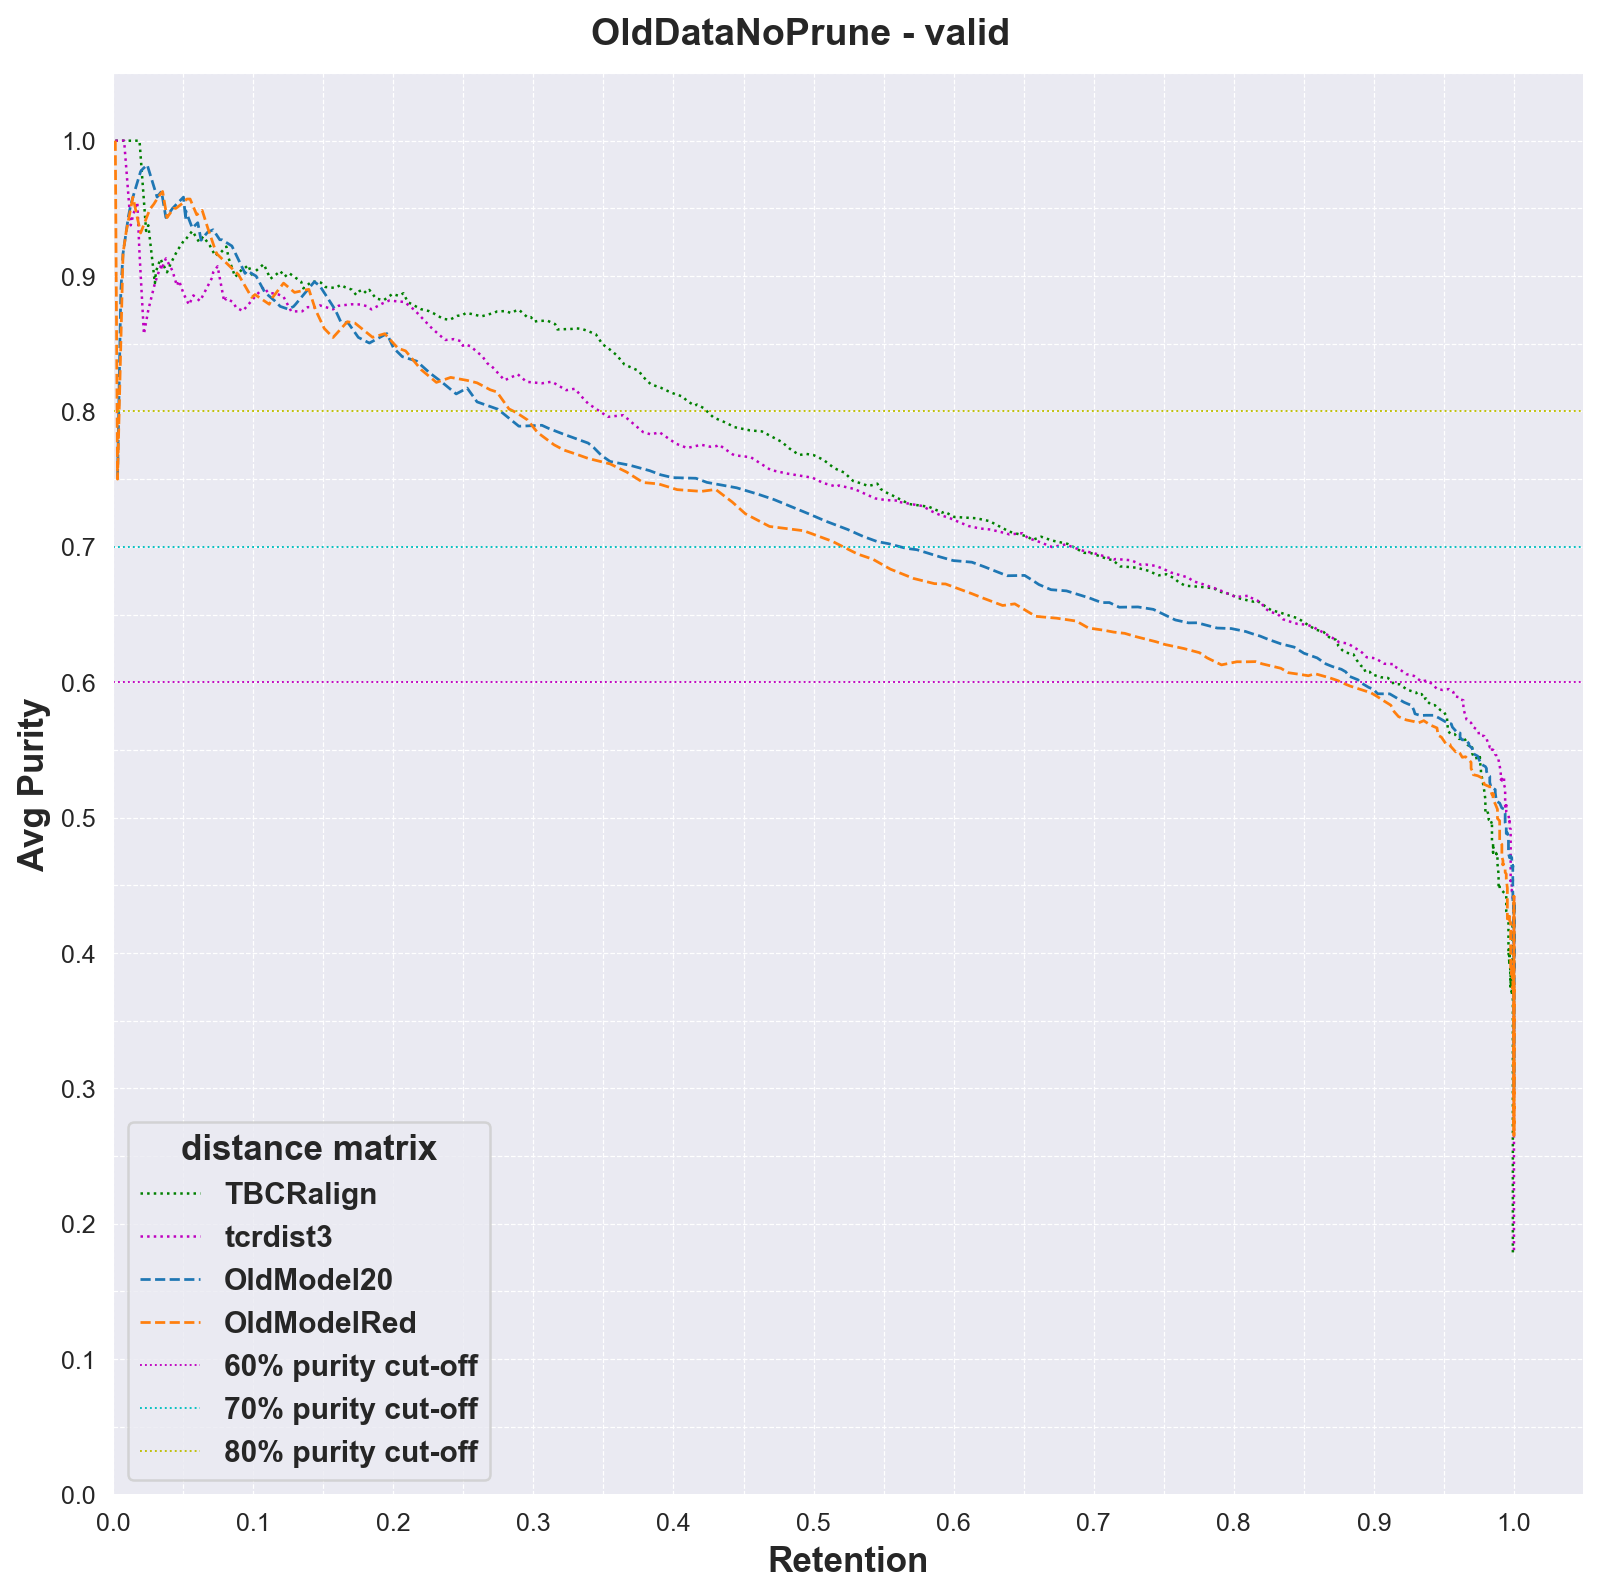

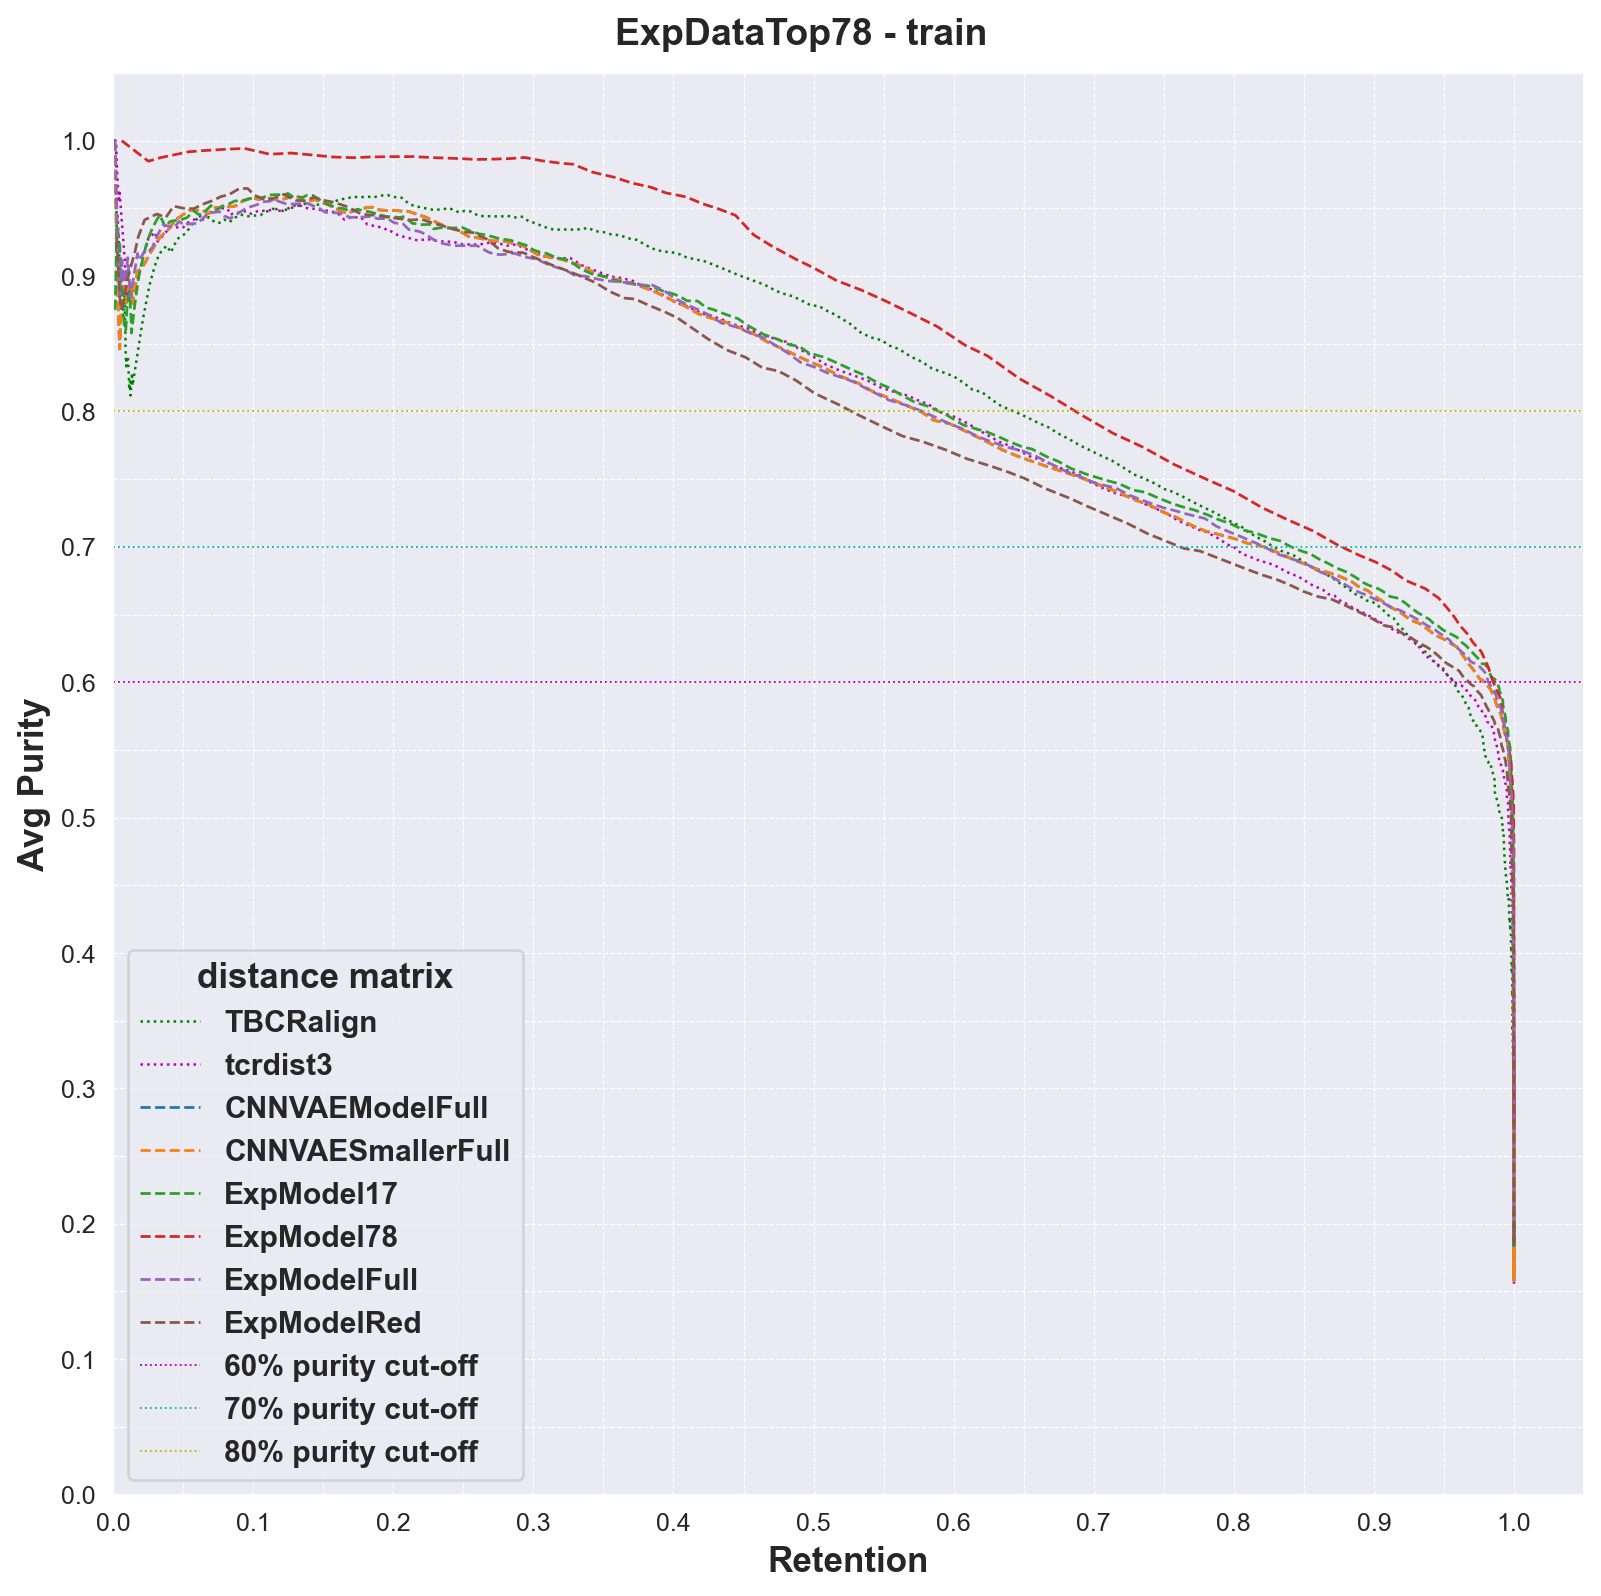

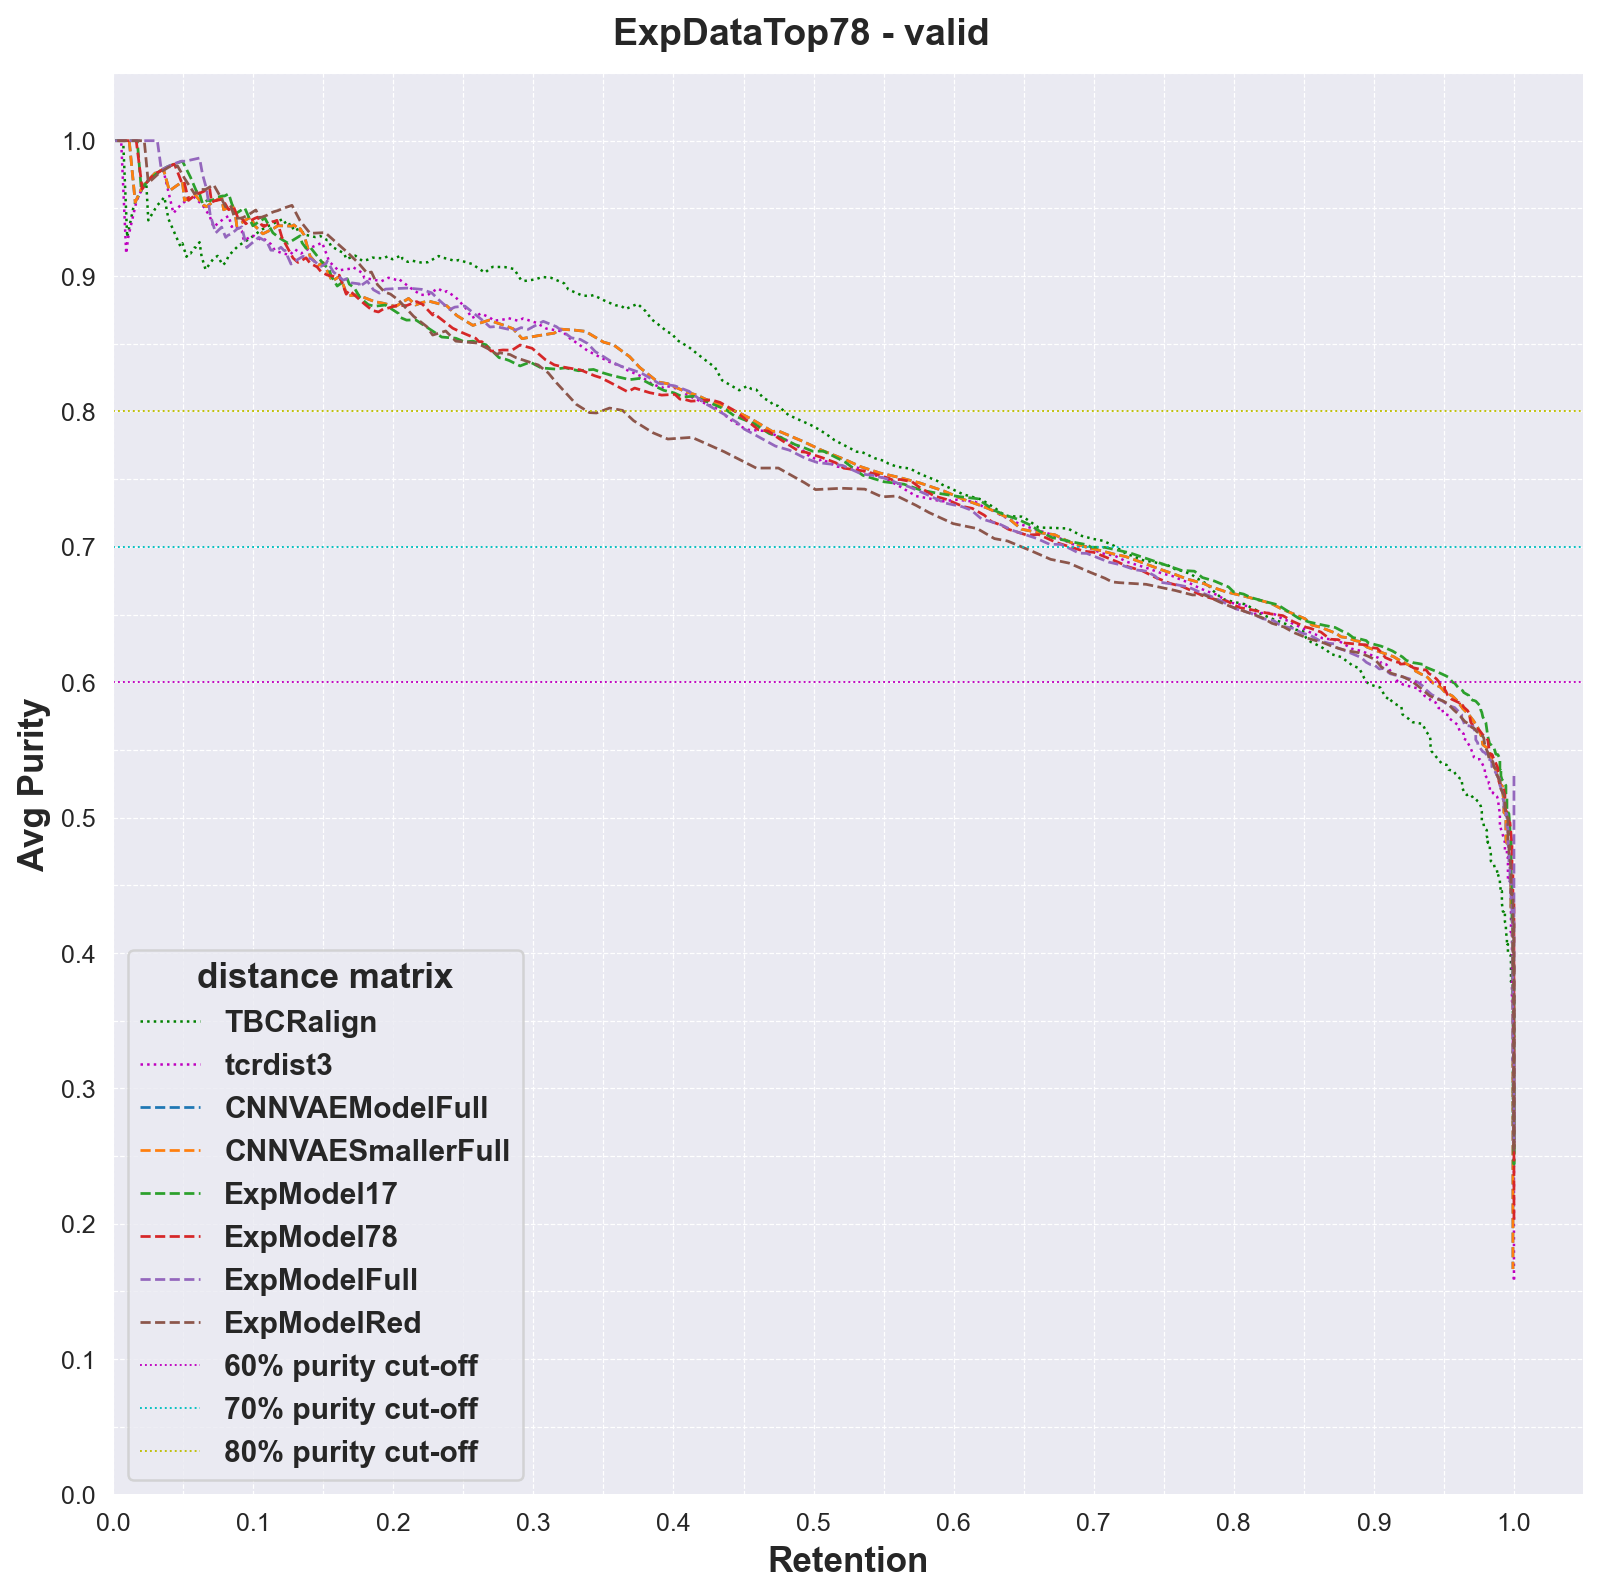

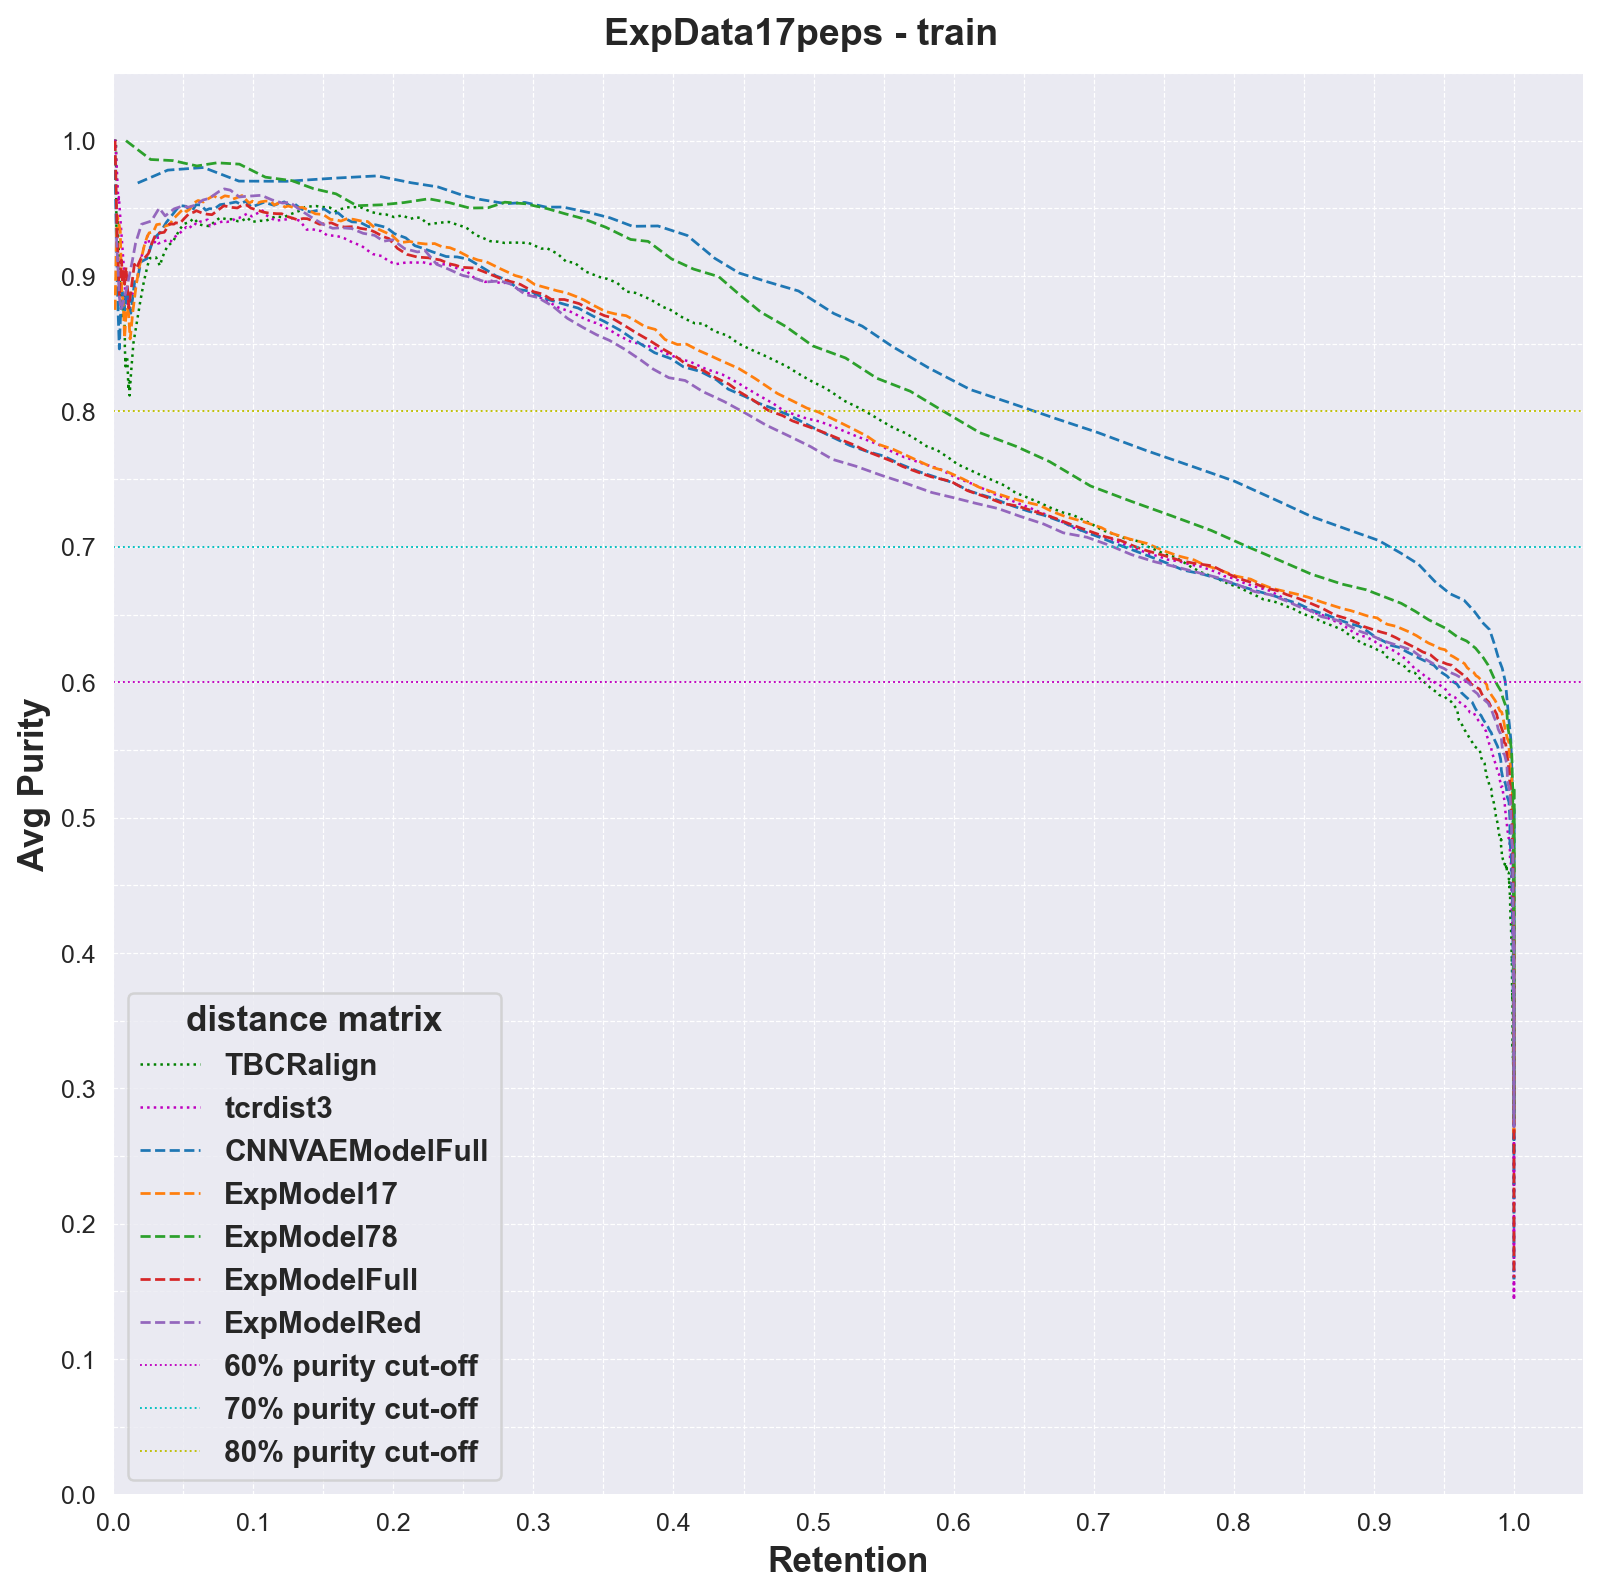

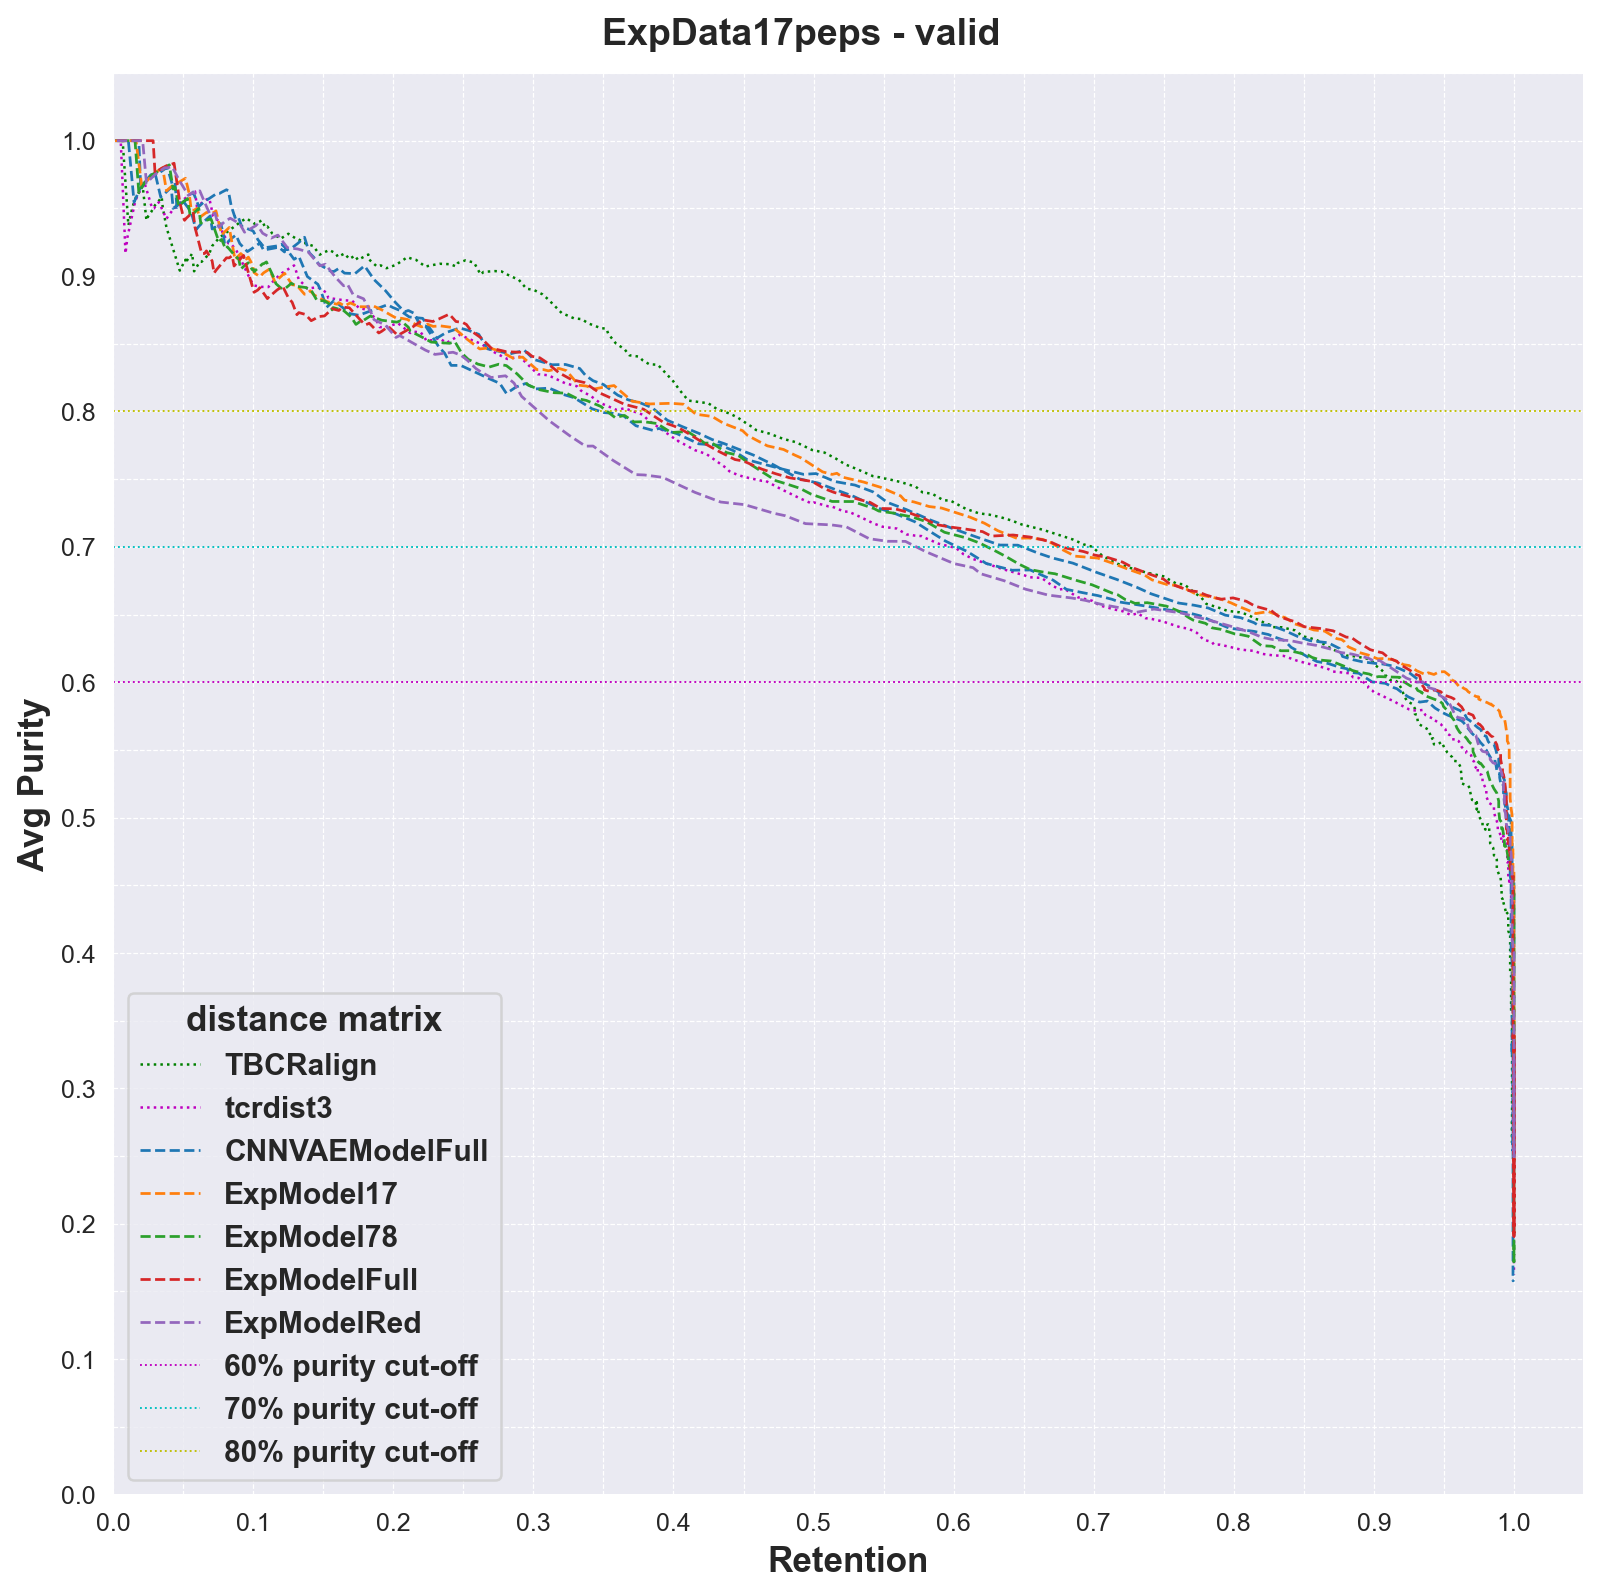

In [62]:
prune_results = {}
savedir = f'../output/240515_IntervalClustering/figs/'
mkdirs(savedir)
for k in ['OldDataTop15', 'OldDataTop20' ,'OldDataNoPrune', 'ExpDataTop78', 'ExpData17peps']:
    prune_results[k] = {}
    for set in ['train', 'valid']:
        prune_results[k][set] = get_best_given_dir(f'../output/240515_IntervalClustering/{k}/', set, k)
        prune_results[k][set].input_type = prune_results[k][set].input_type.apply(lambda x: x.split('_'+k)[0])
        plot_pipeline_all(prune_results[k][set], f'{k} - {set}', f'{savedir}{k}_{set}', 'tab10')

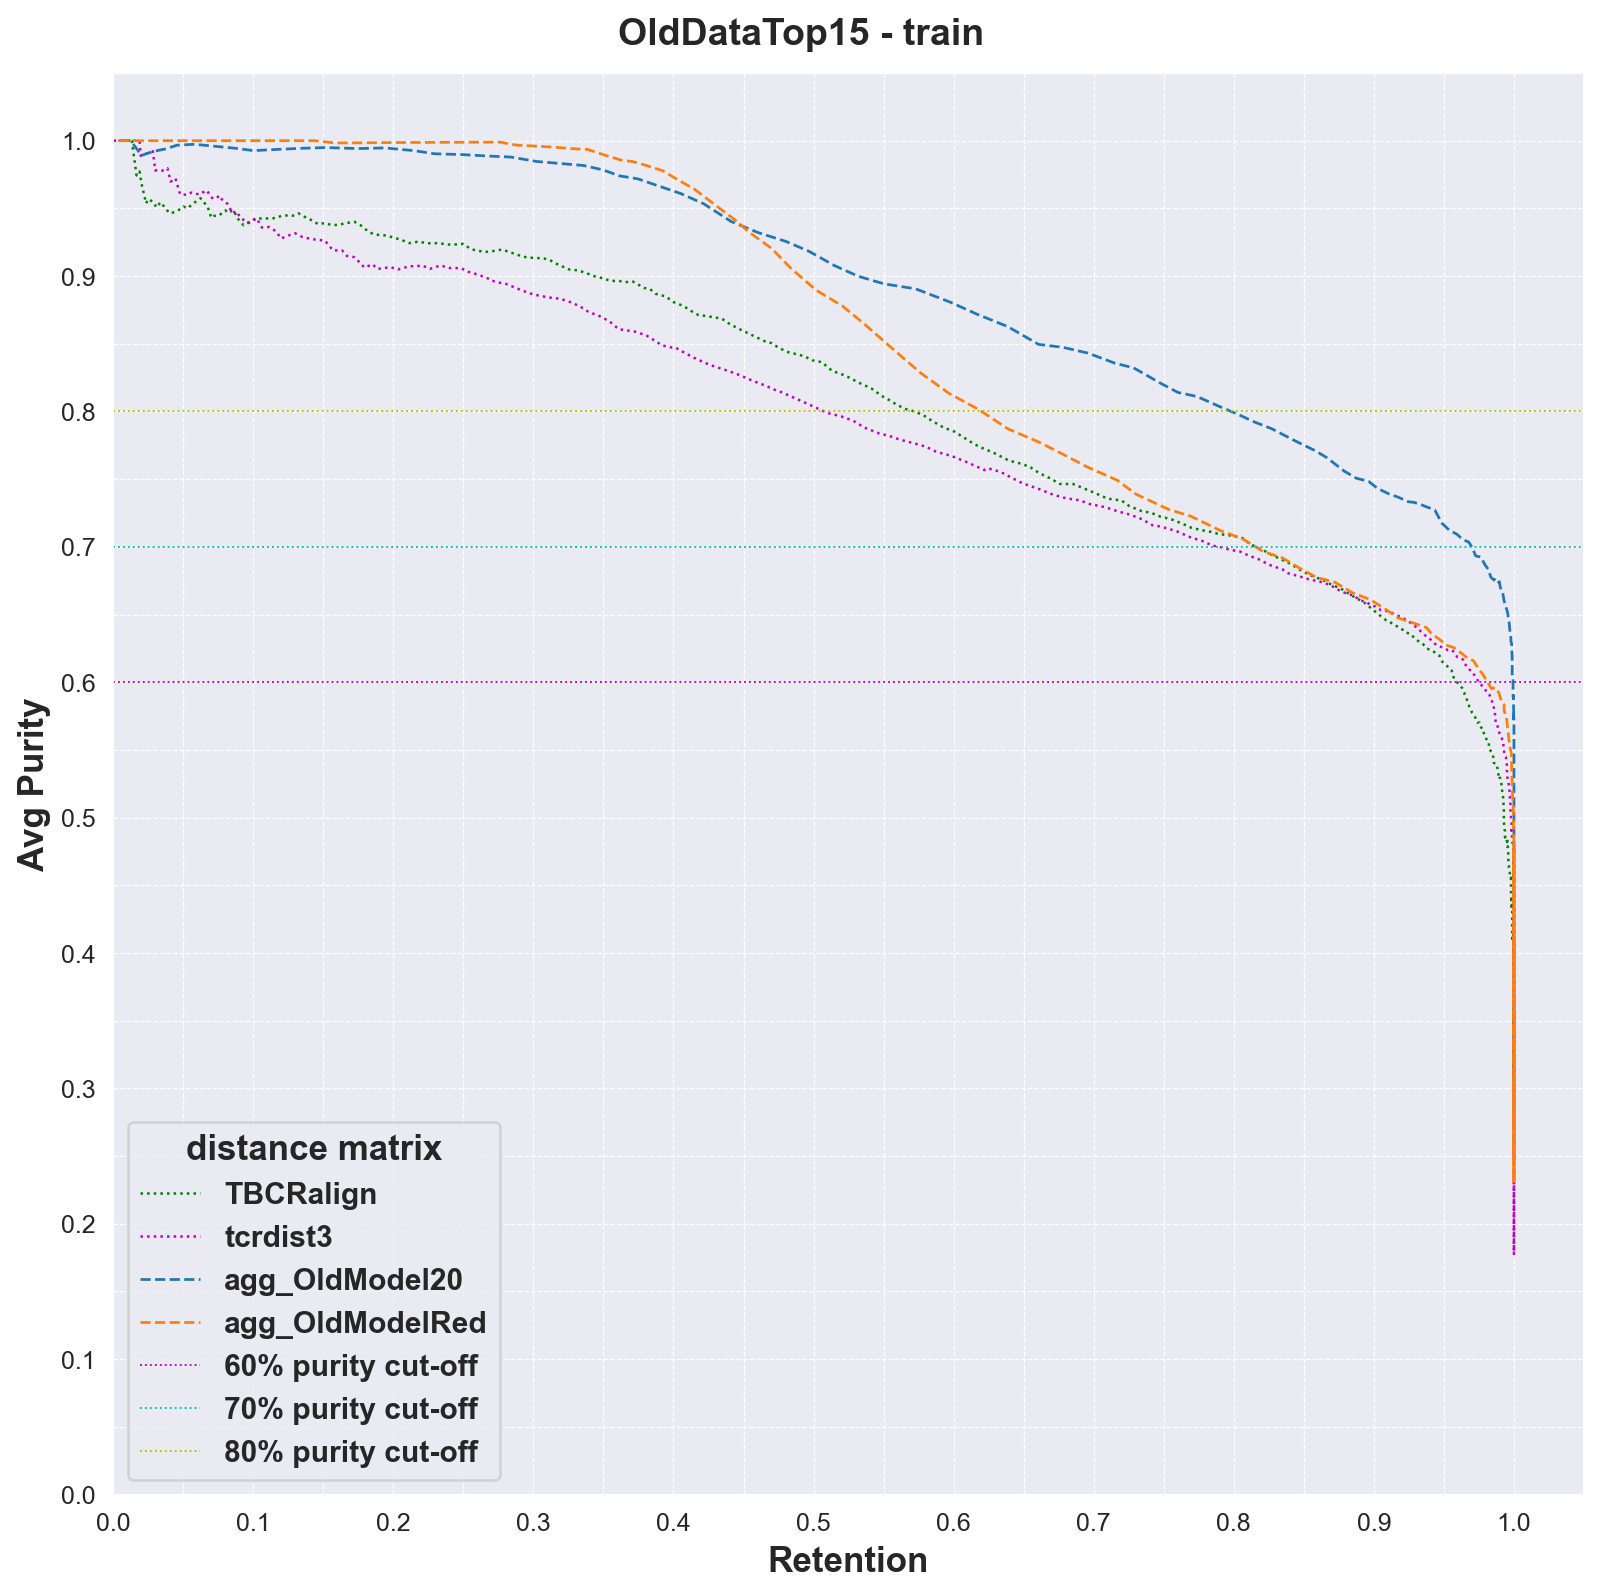

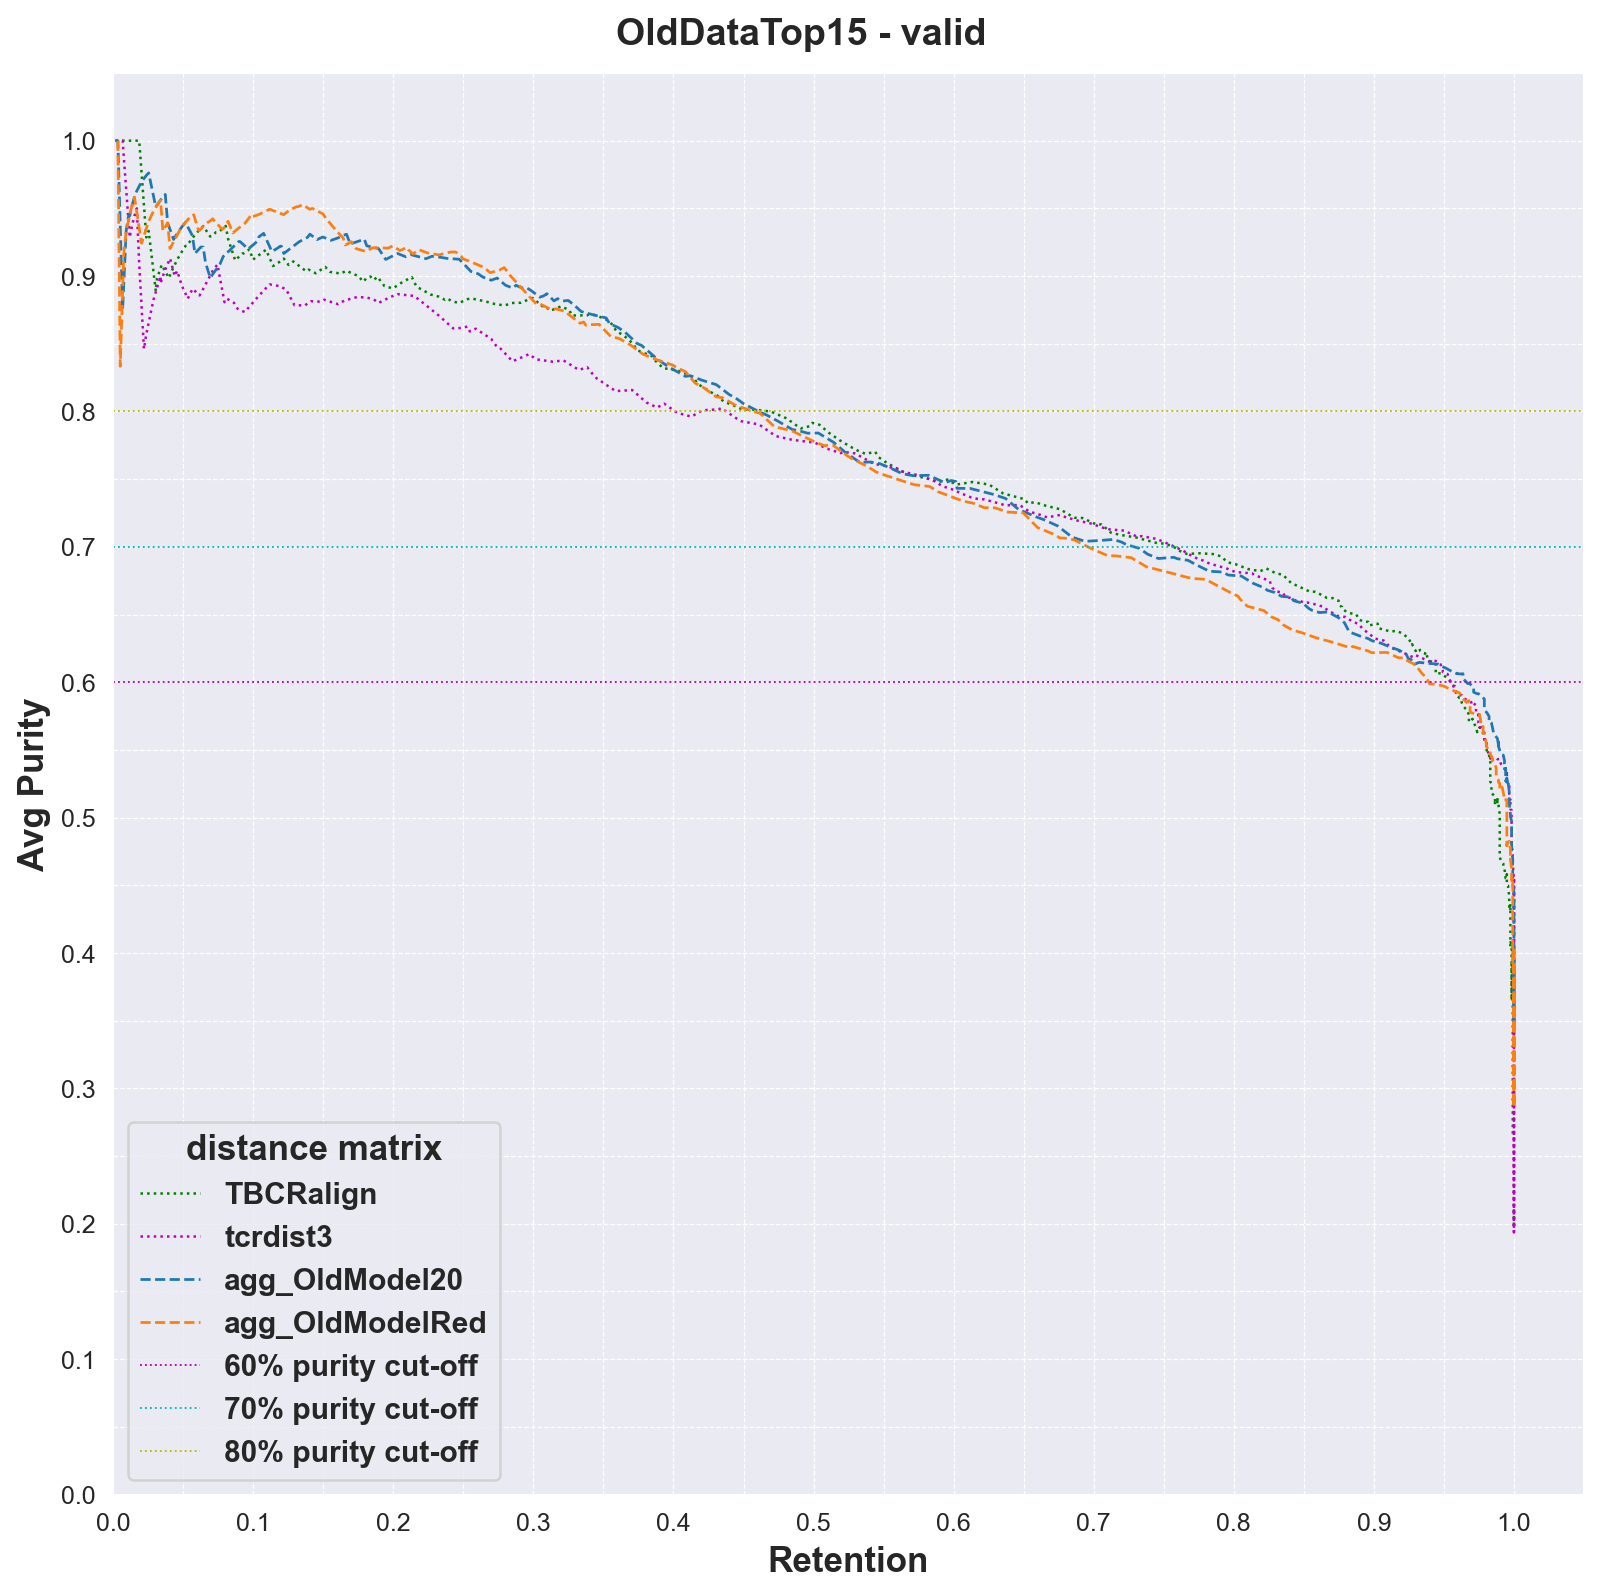

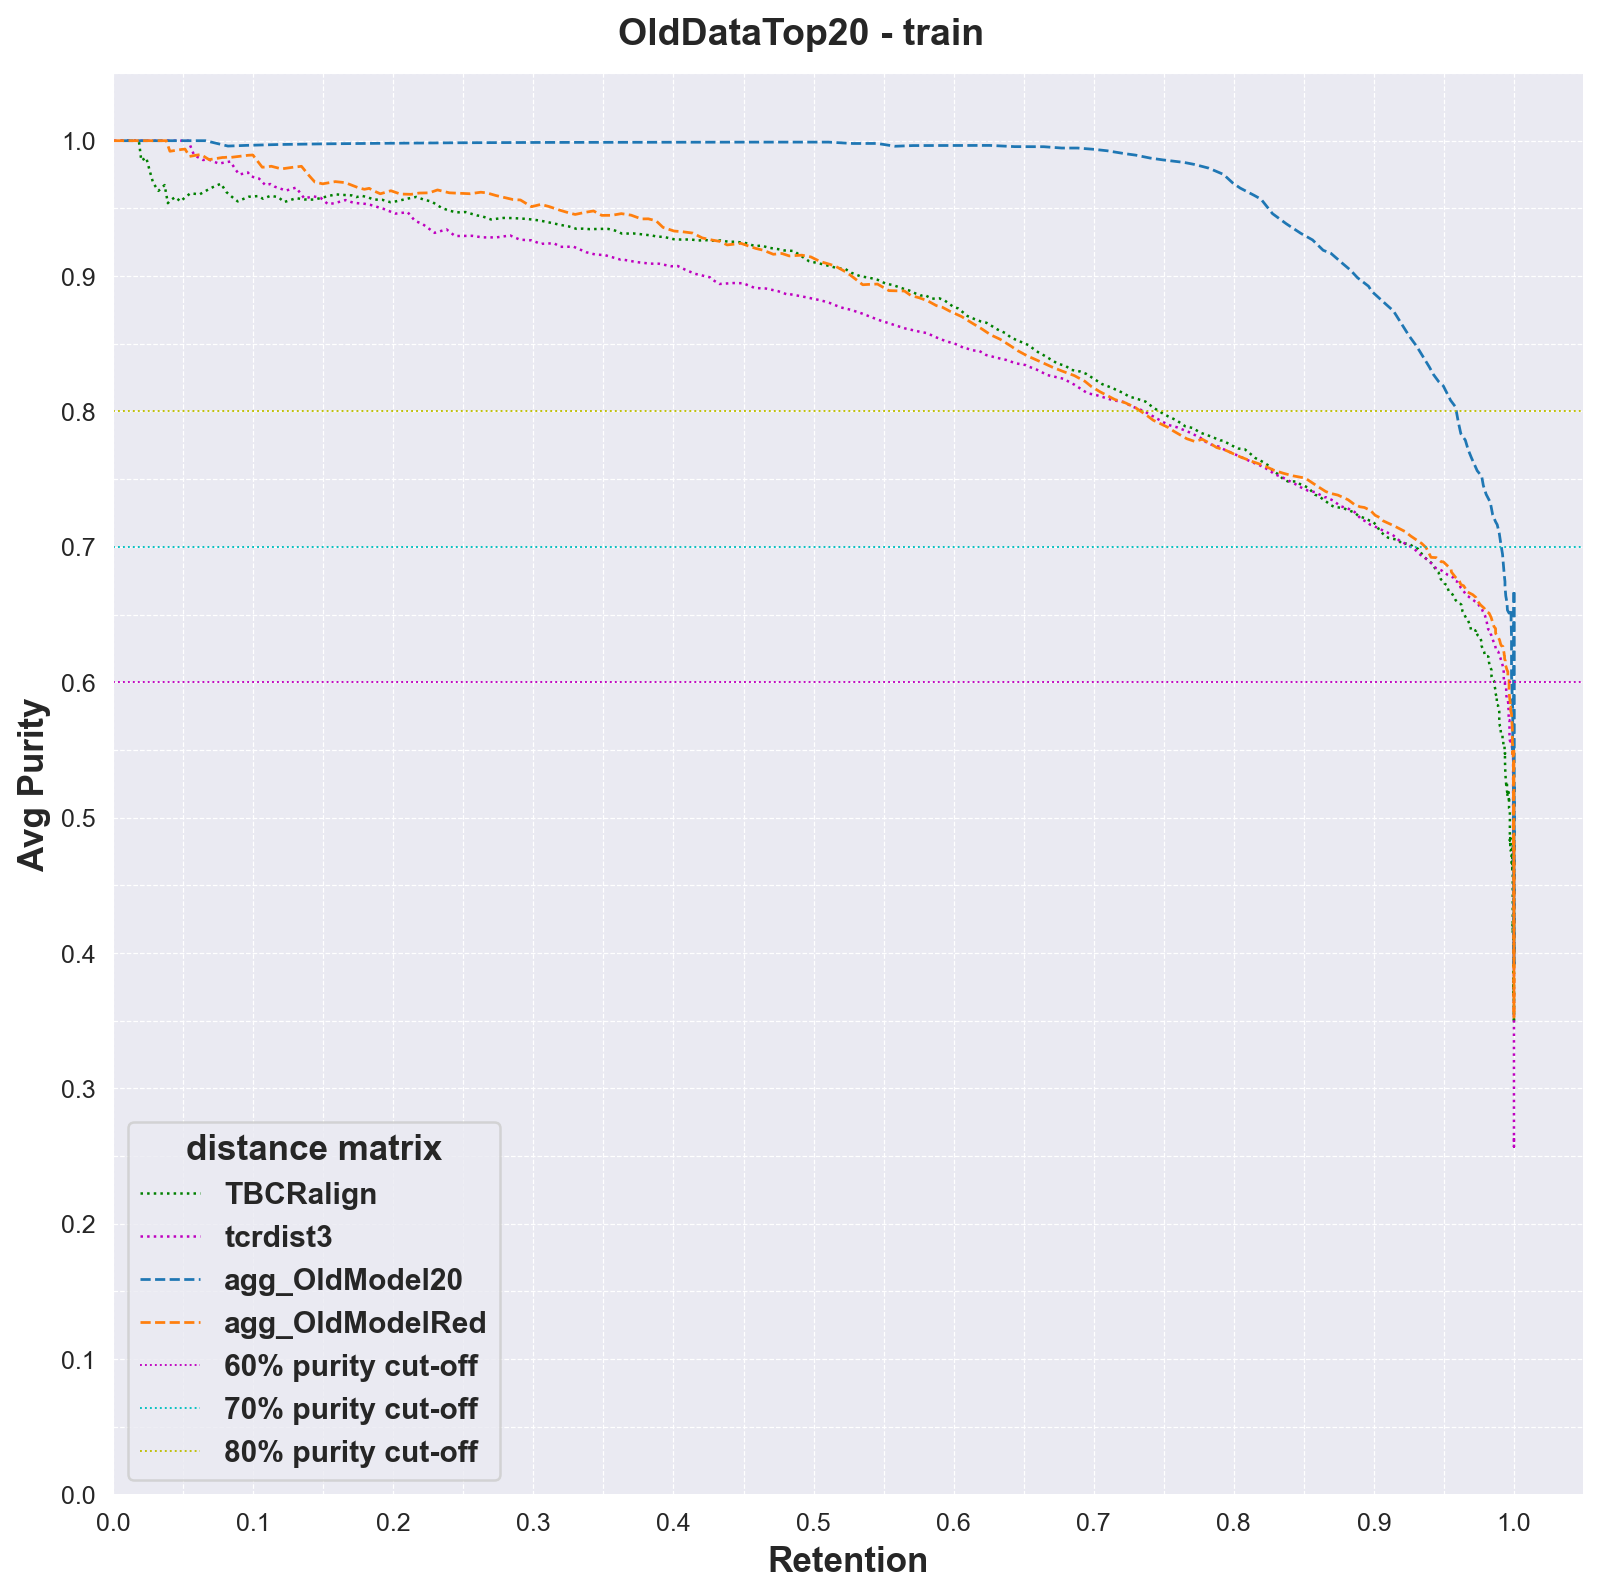

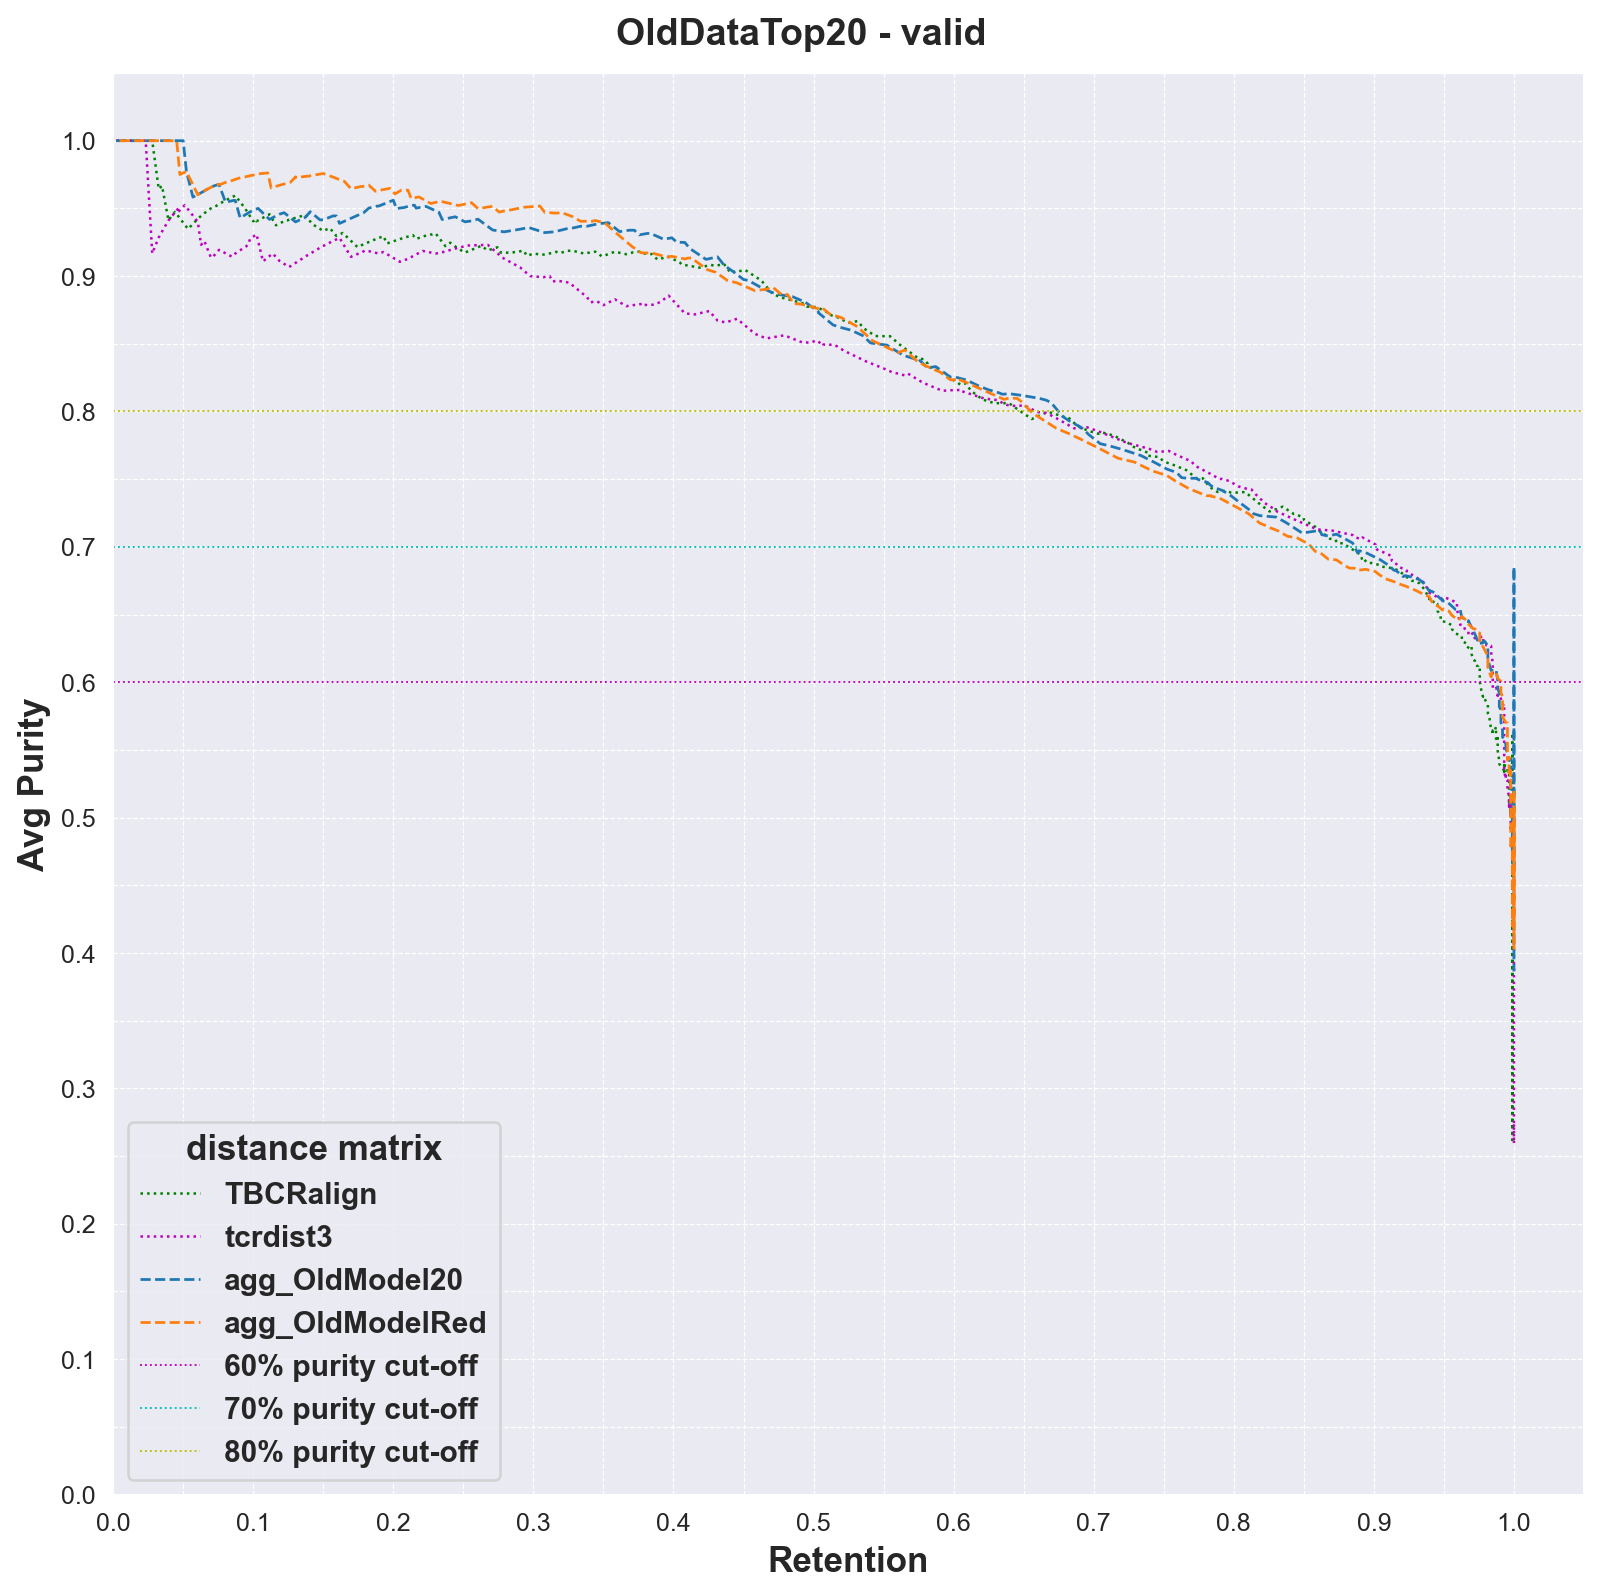

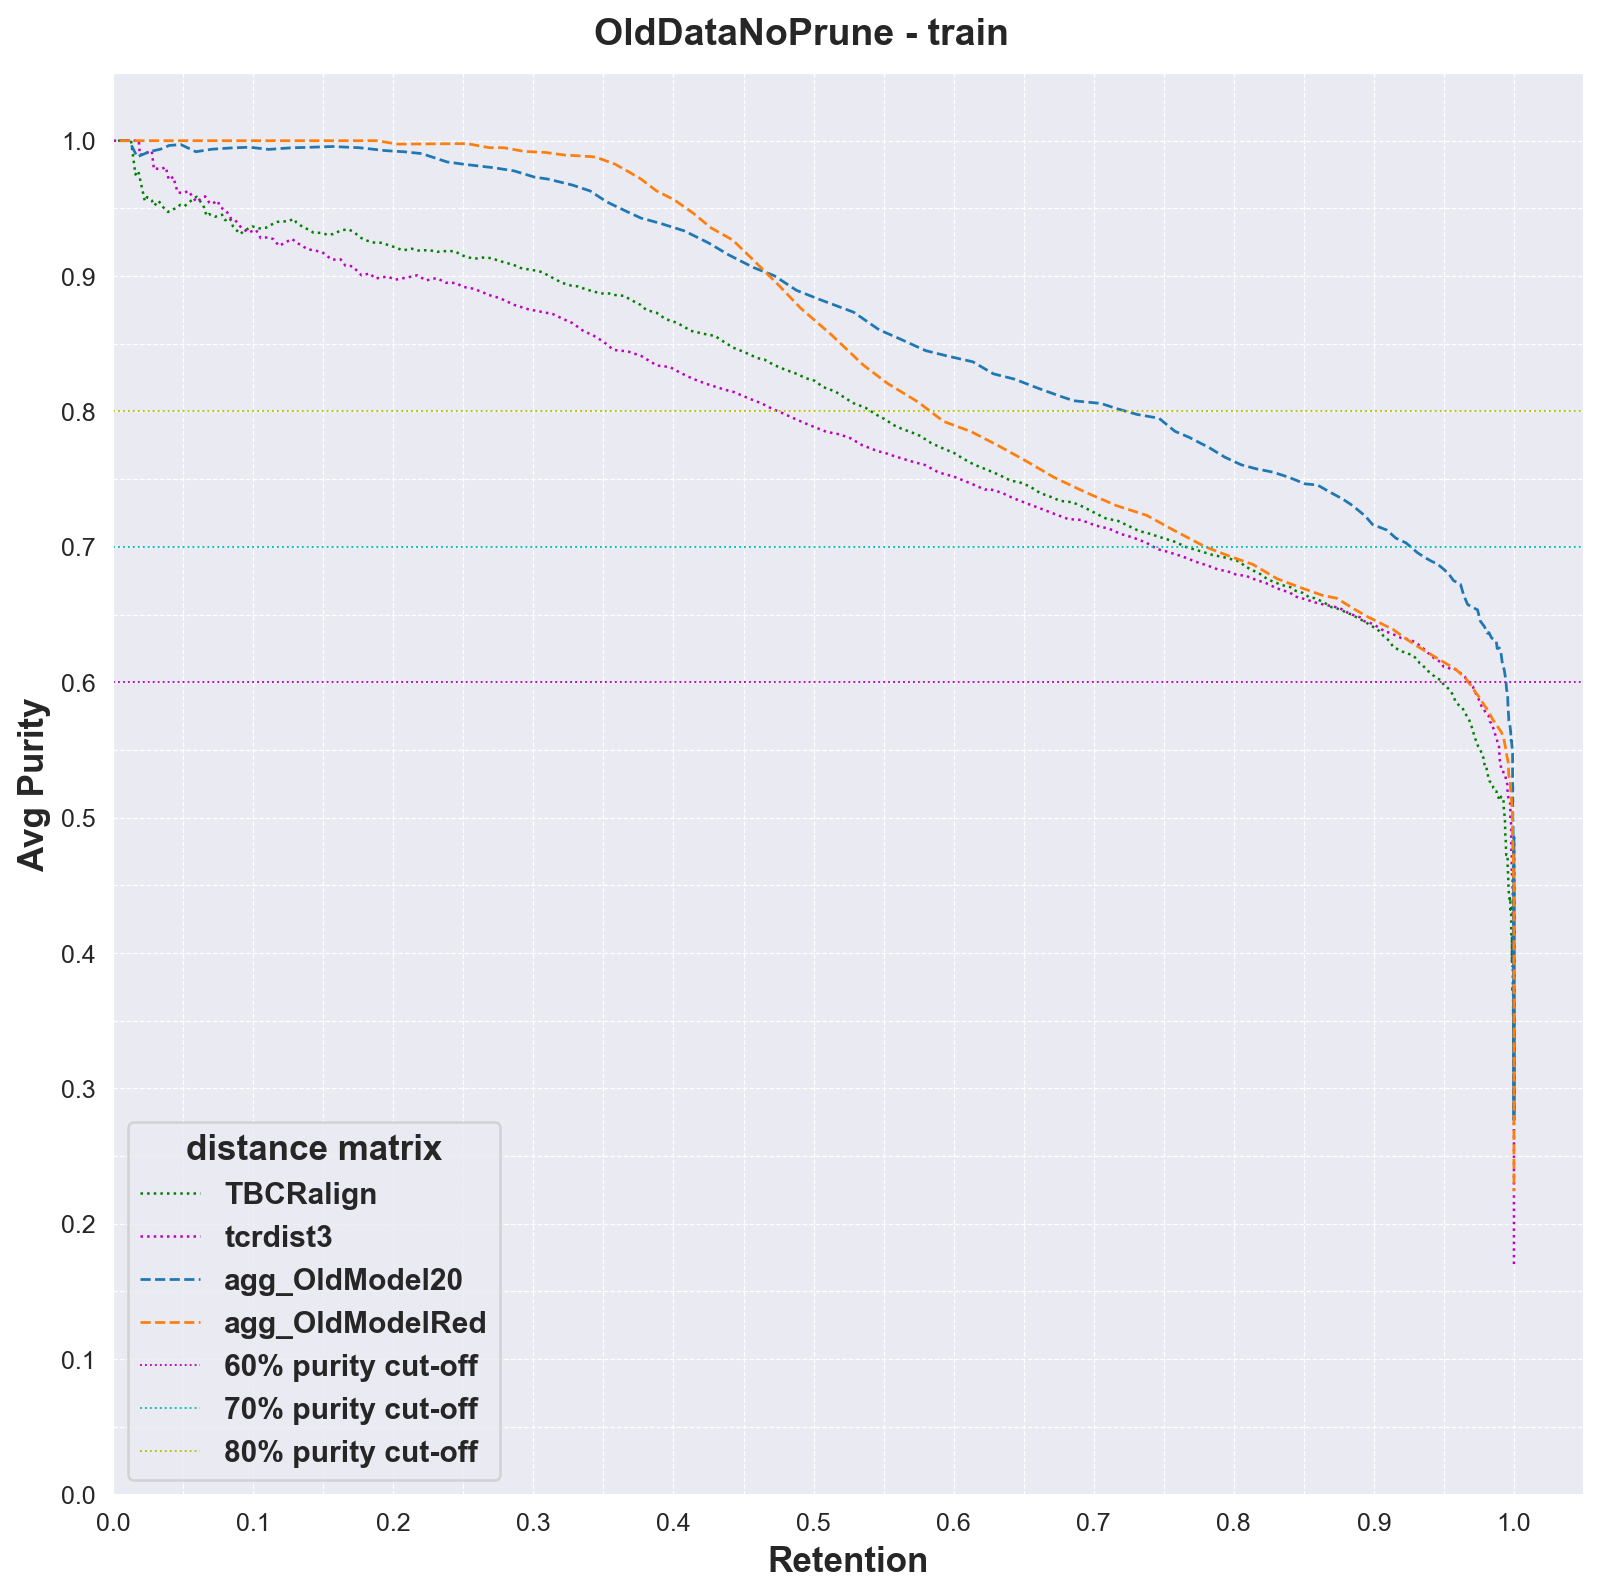

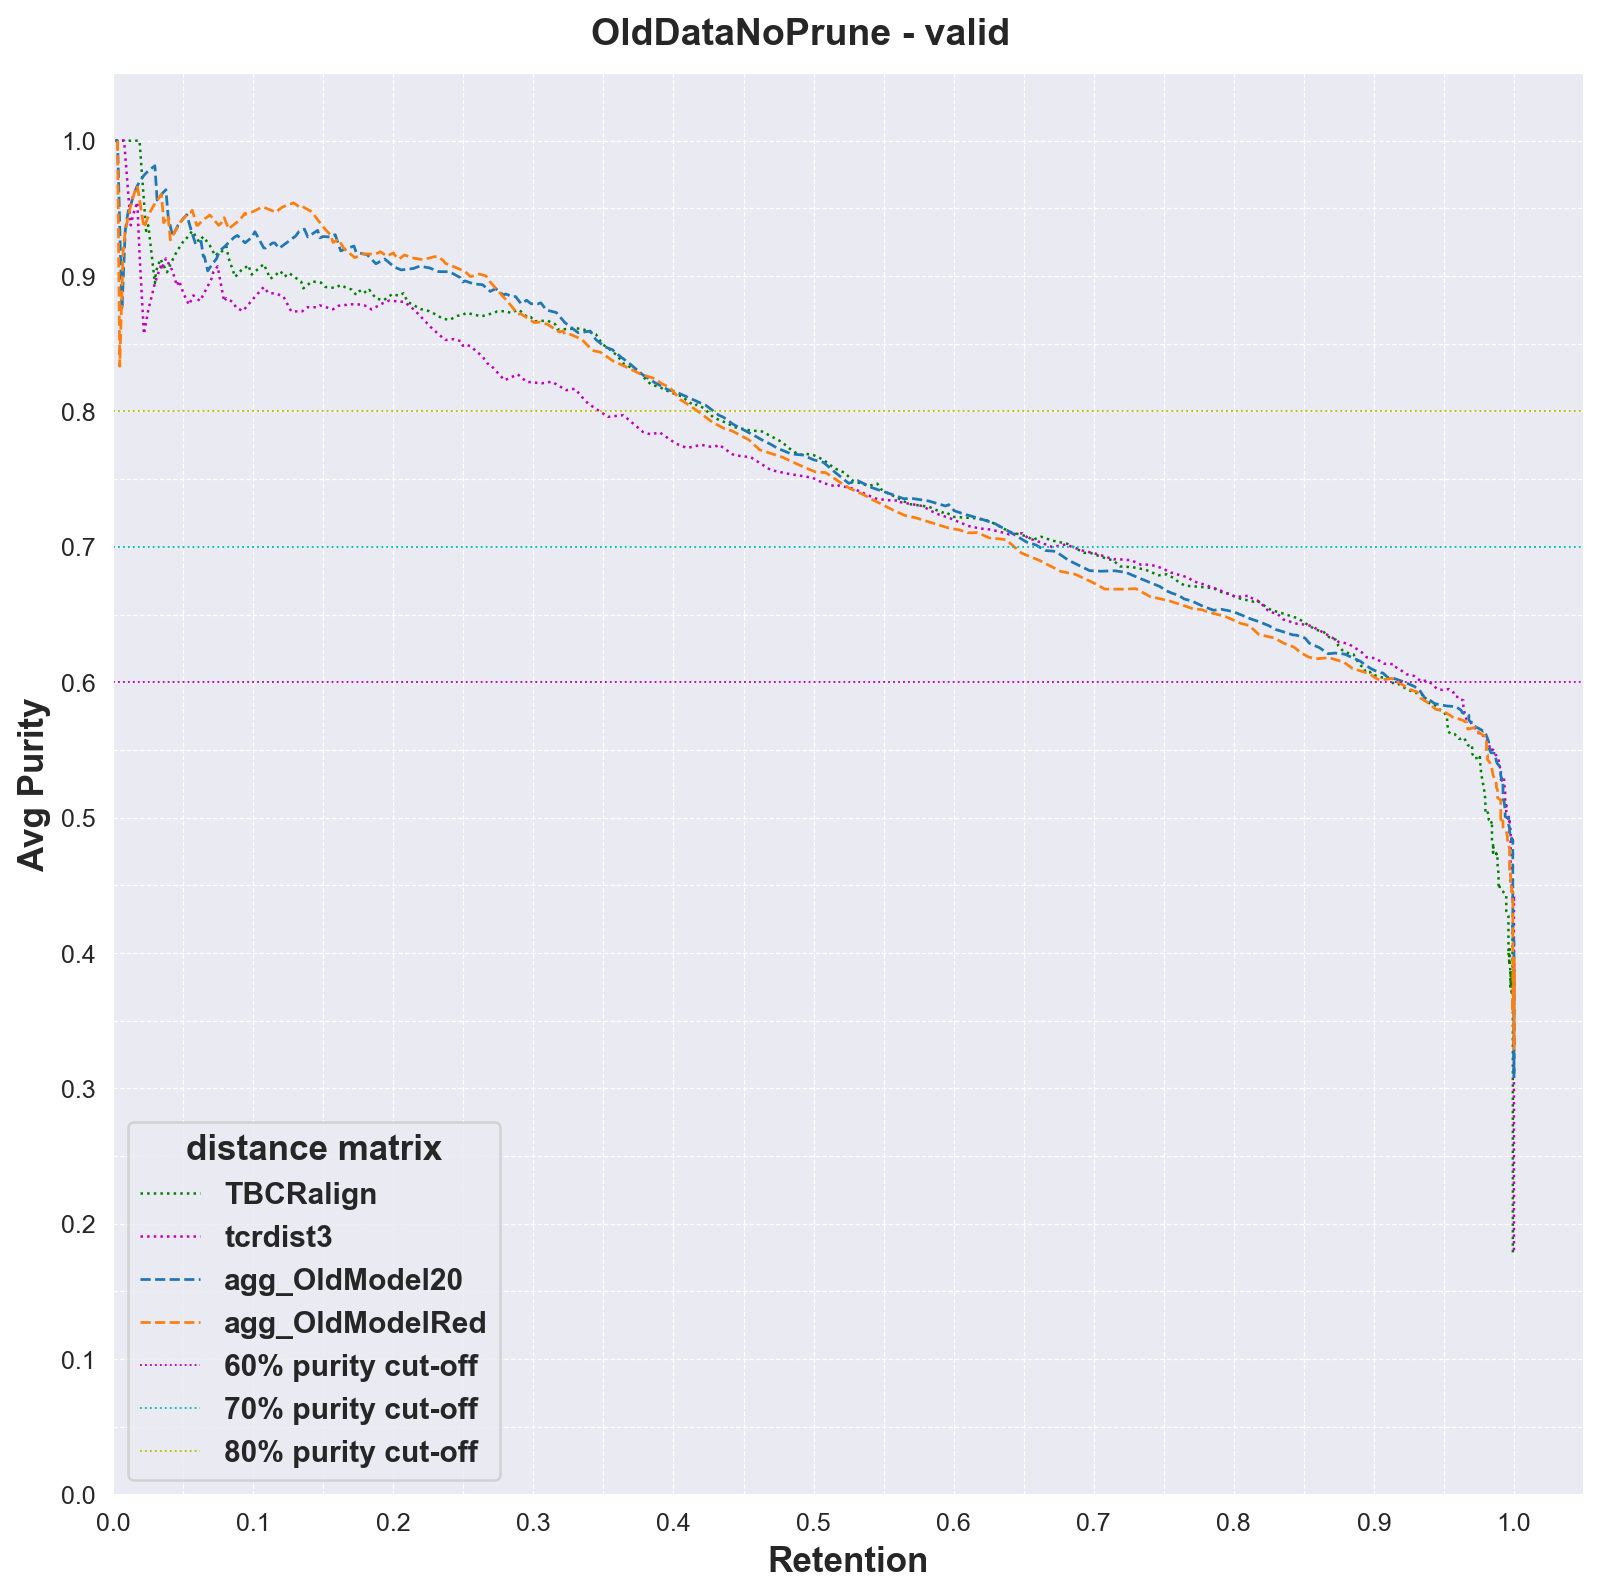

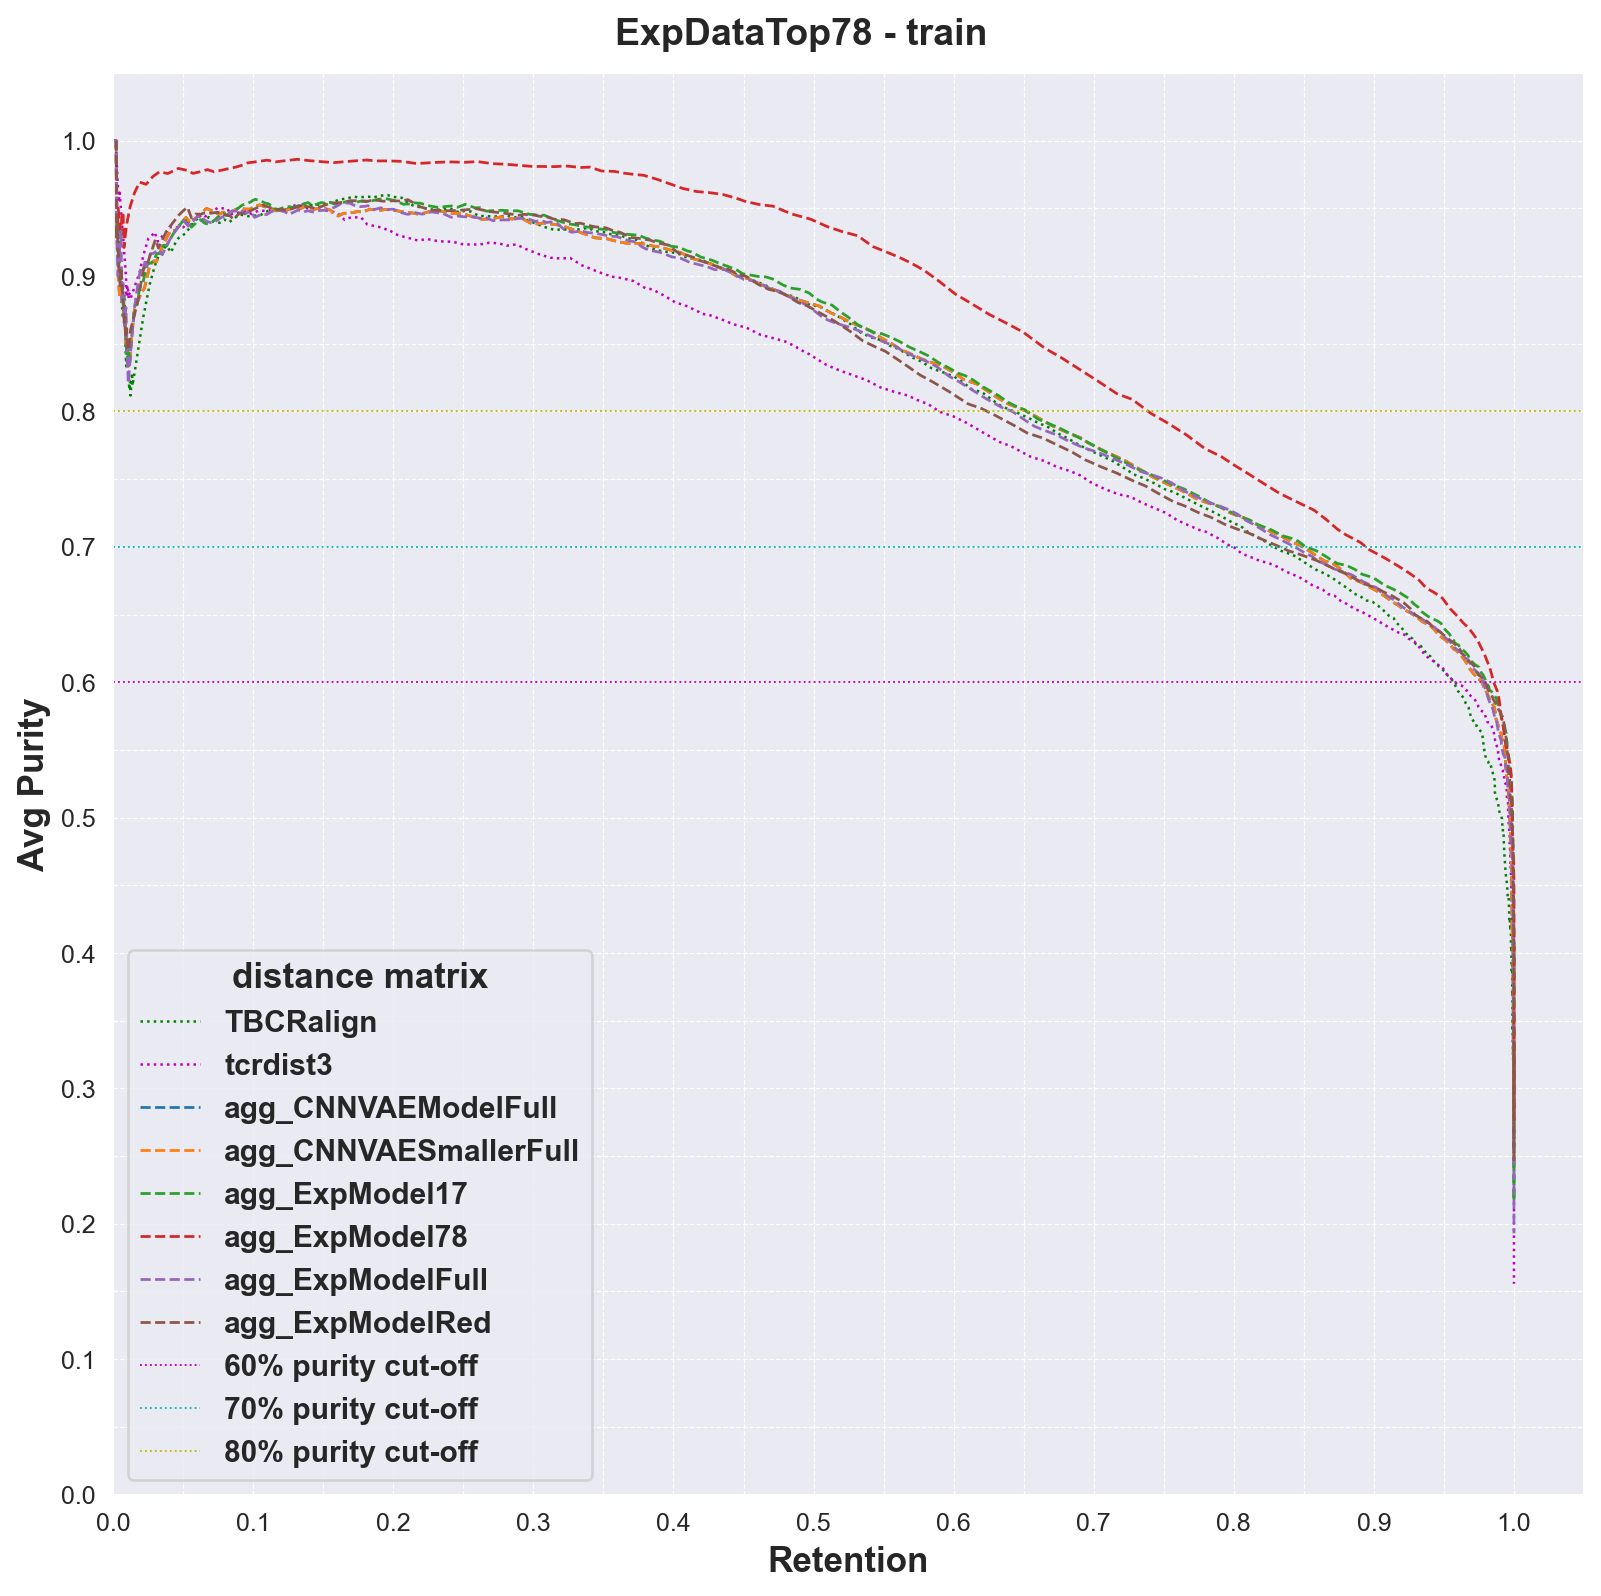

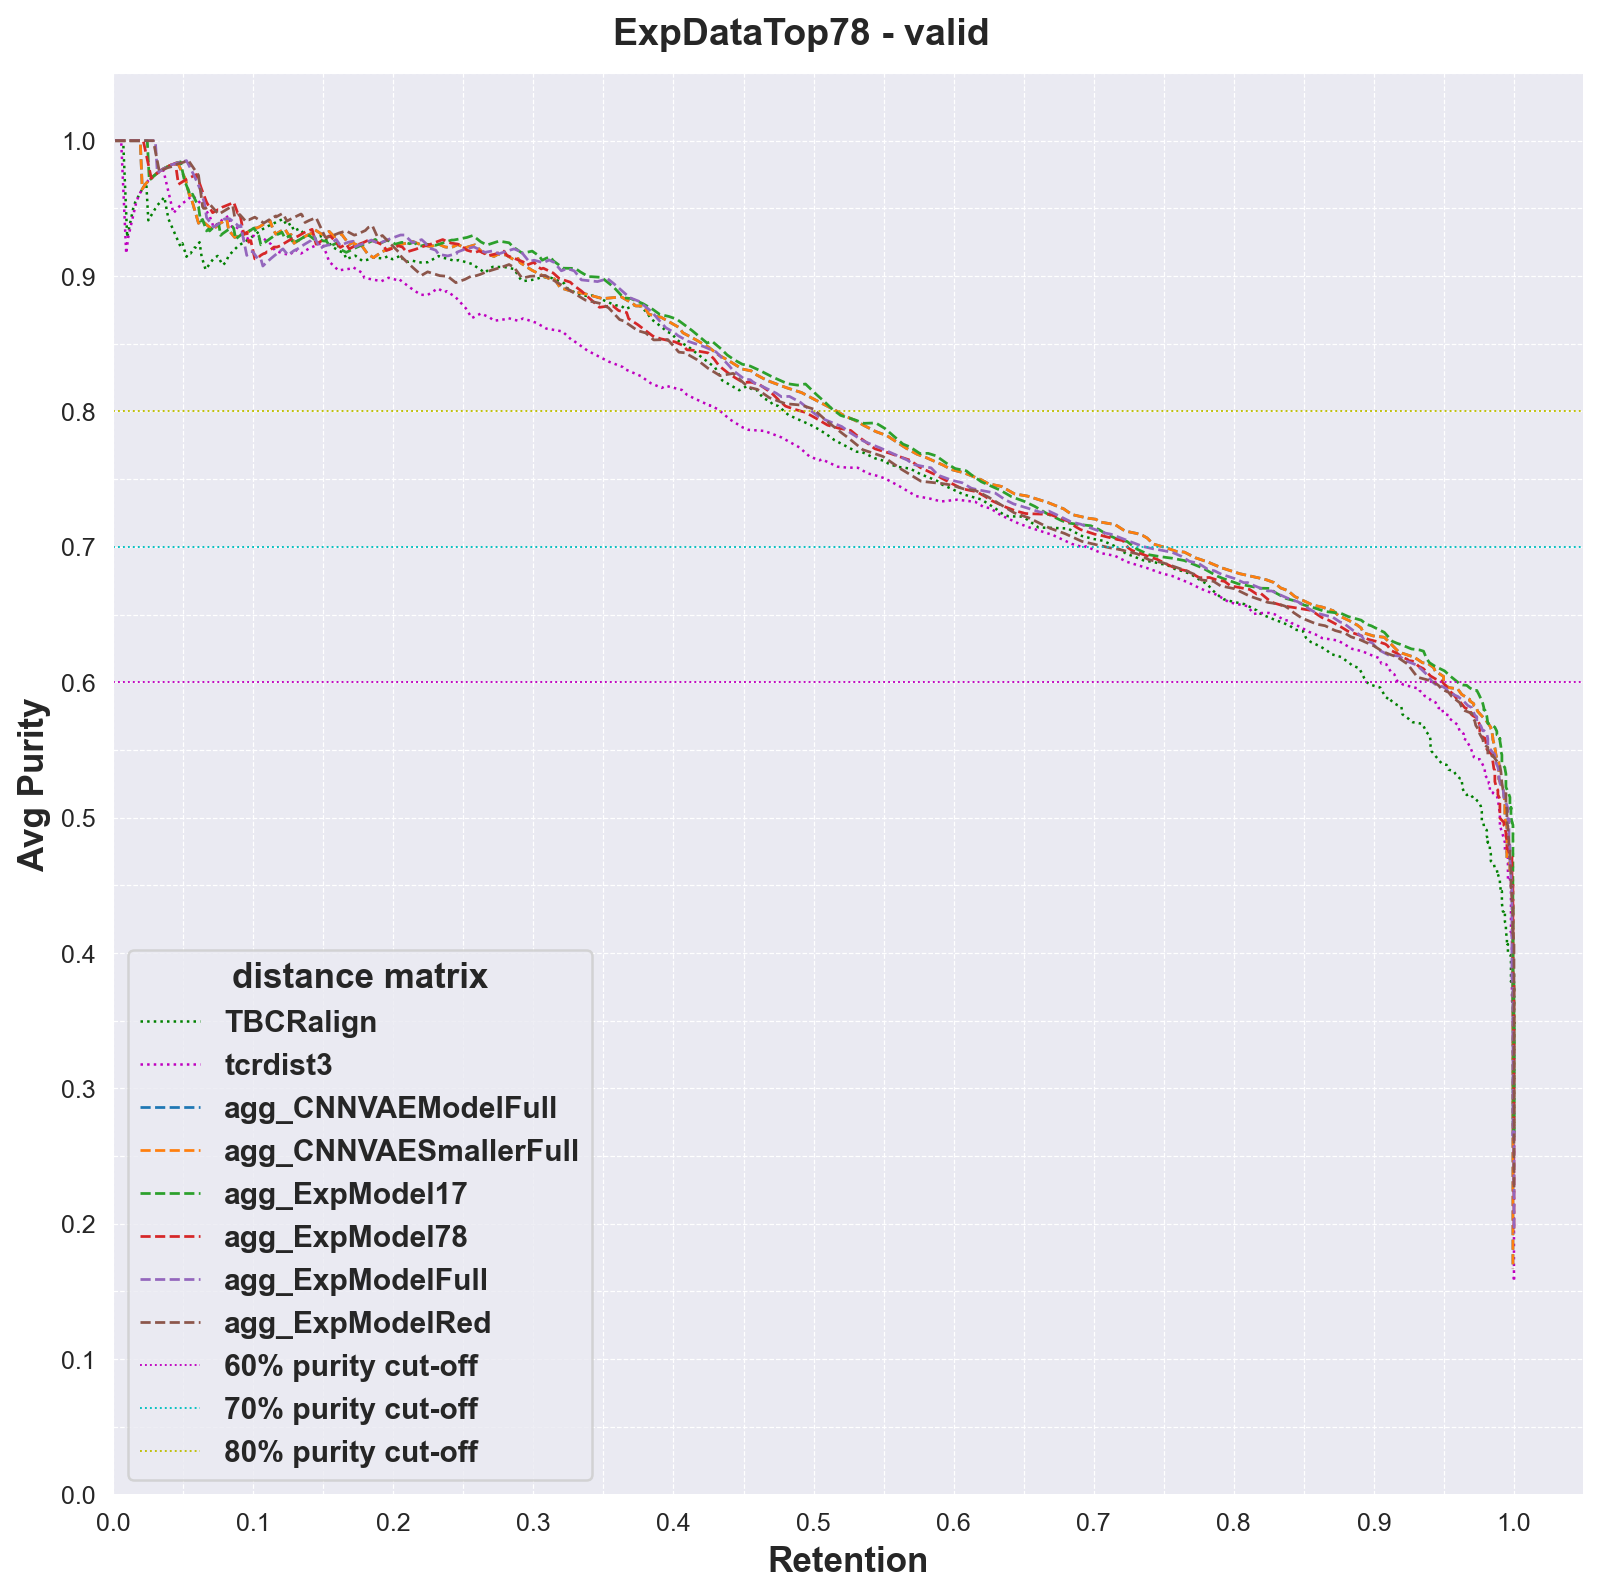

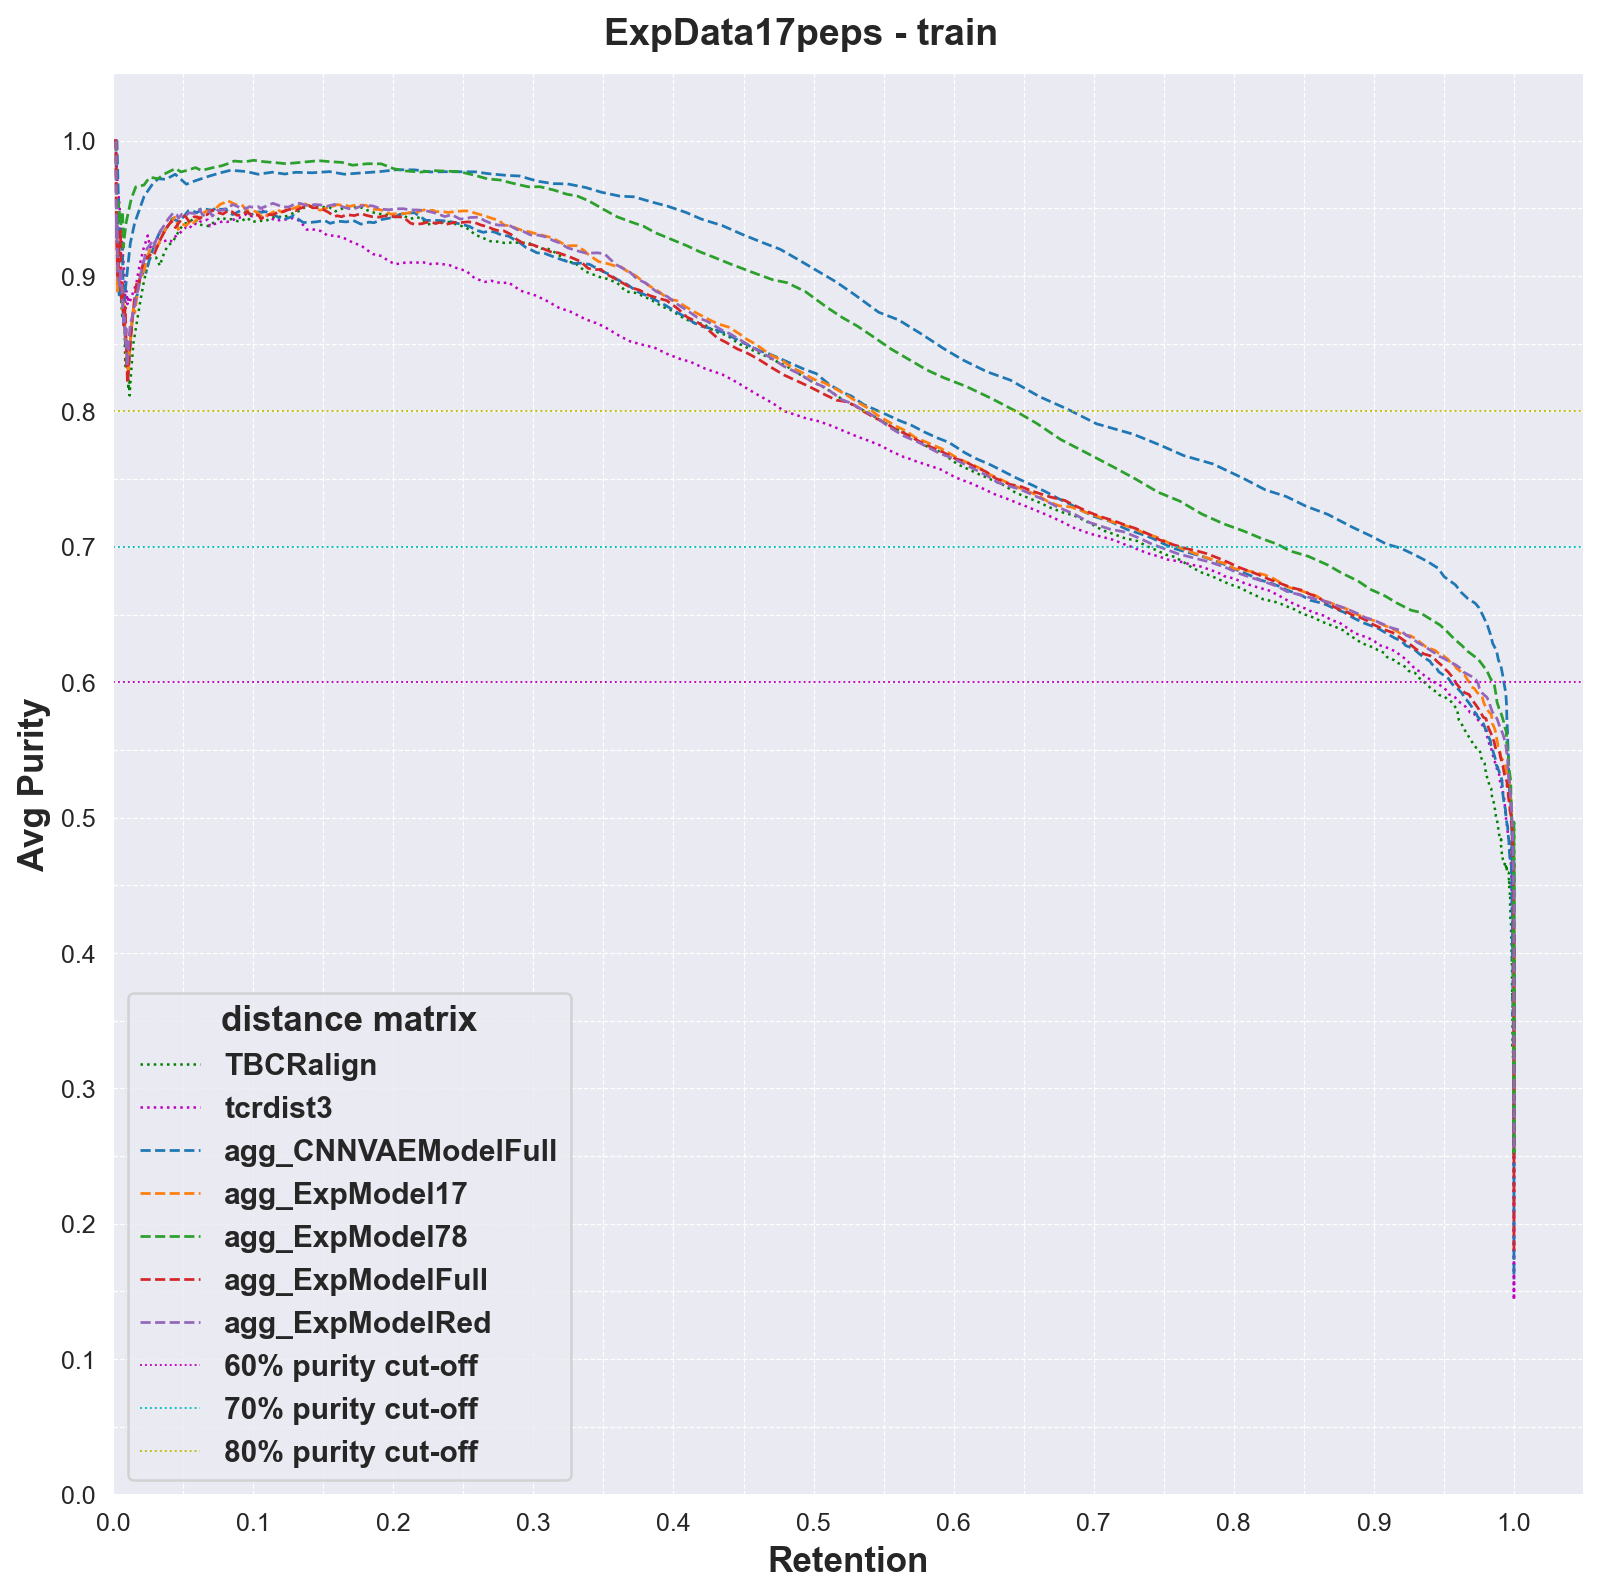

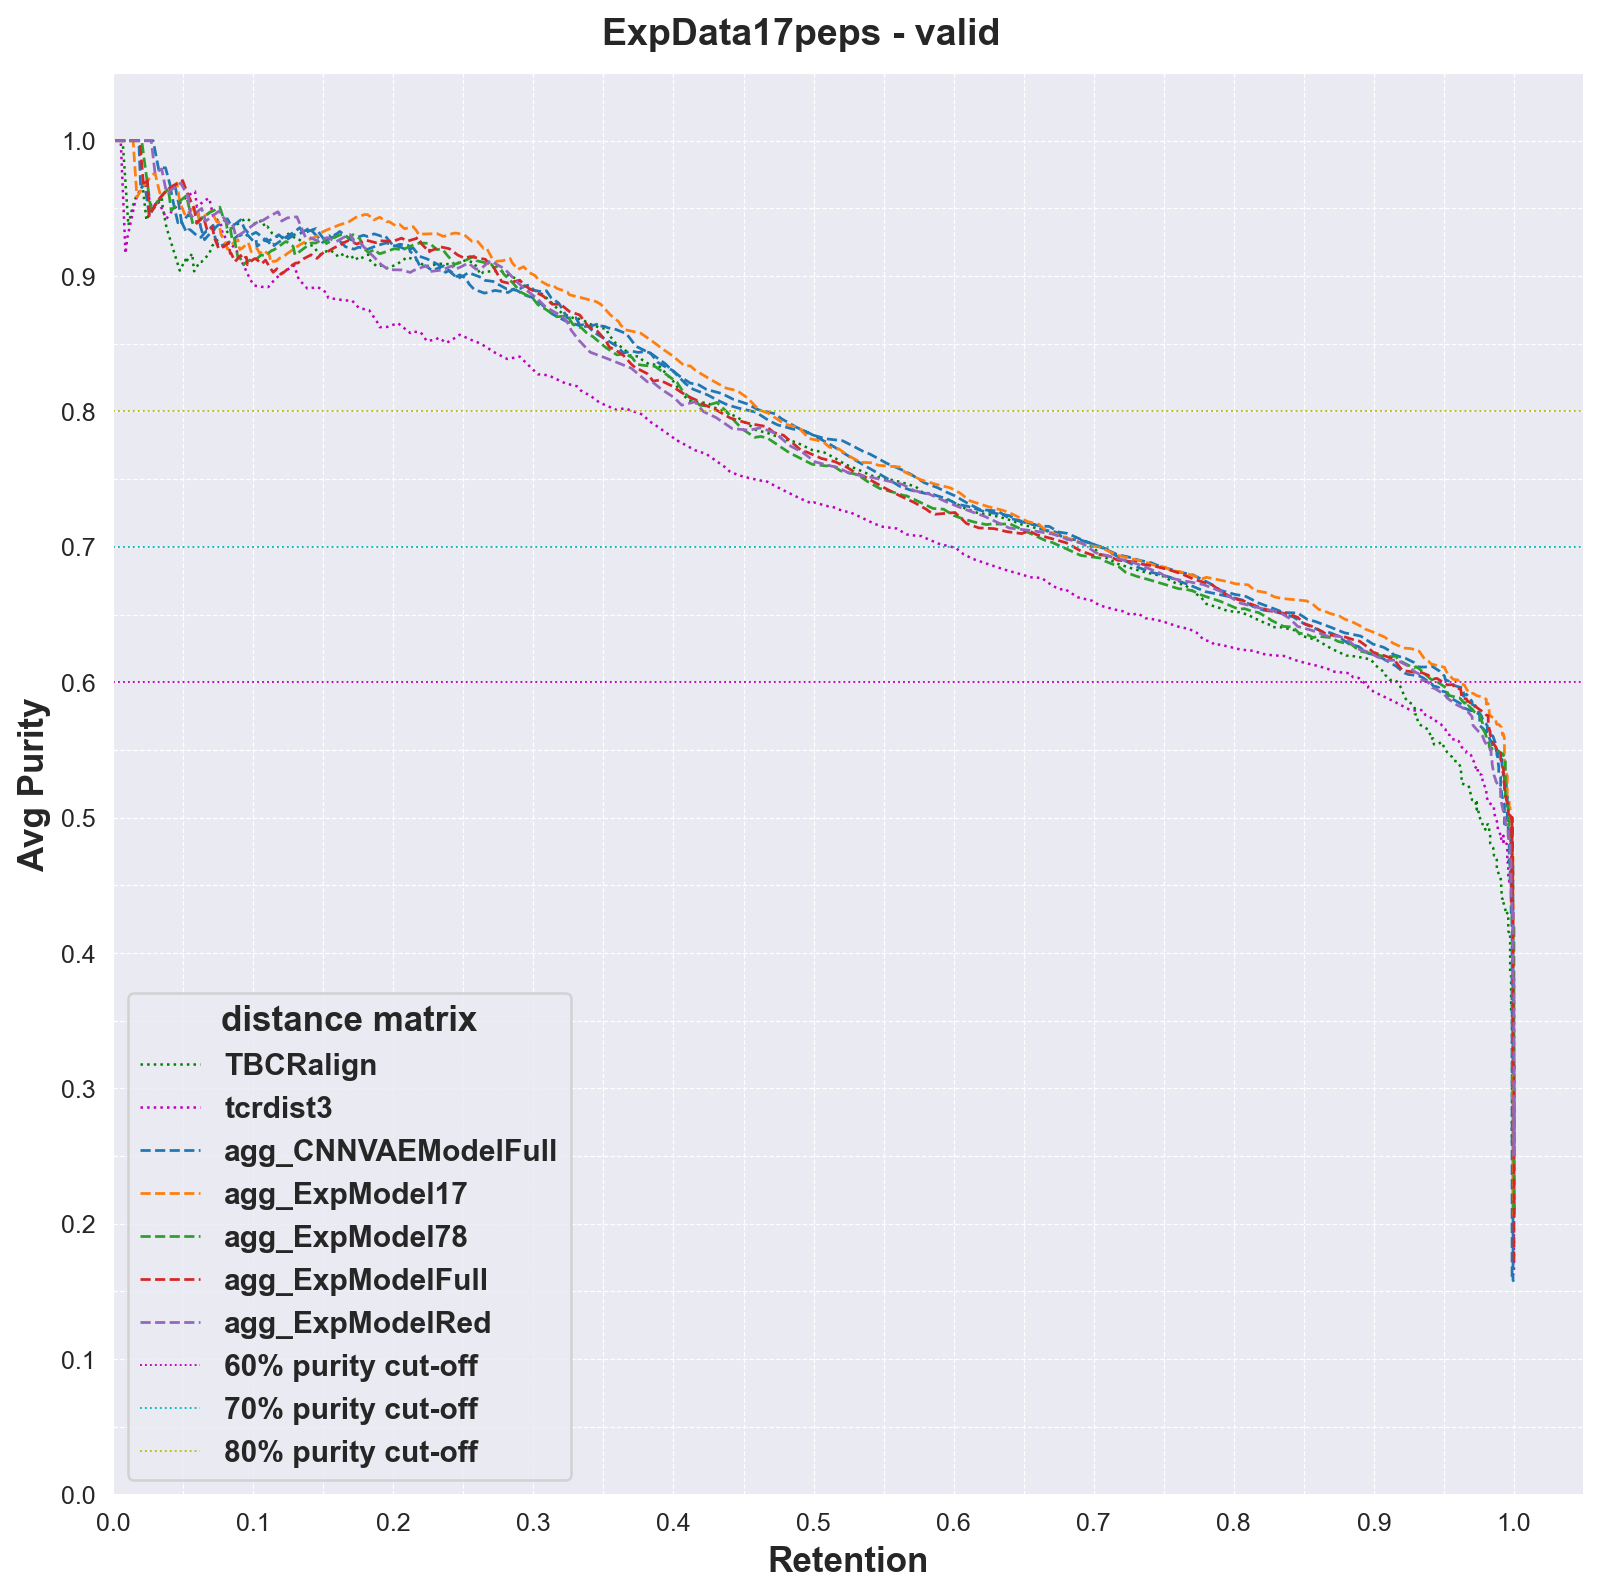

In [64]:
prune_agg_results = {}
savedir = f'../output/240515_IntervalClustering/figs/'
mkdirs(savedir)
for k in ['OldDataTop15', 'OldDataTop20' ,'OldDataNoPrune', 'ExpDataTop78', 'ExpData17peps']:
    prune_agg_results[k] = {}
    for set in ['train', 'valid']:
        prune_agg_results[k][set] = get_agg_given_dir(f'../output/240515_IntervalClustering/{k}/', set, k)
        prune_agg_results[k][set].input_type = prune_agg_results[k][set].input_type.apply(lambda x: x.split('_'+k)[0])
        plot_pipeline_all(prune_agg_results[k][set], f'{k} - {set}', f'{savedir}AggModels_{k}_{set}', 'tab10')

## Old Data

# NXMinimum spanning trees

In [17]:
import networkx as nx
from src.cluster_utils import *

In [13]:
files_dict = pkl_load('../output/240411_ClusteringTests/files_dict.pkl')
comp_dict = pkl_load('../output/240411_ClusteringTests/comp_dict.pkl')

In [37]:
# Select the best model from FullExp 0200 KL 1e-1
folder = files_dict['FullExp_KL_1e-1']
join = '_'.join([comp_dict['FullExp_KL_1e-1'][-2], comp_dict['FullExp_KL_1e-1'][-1]])+'_'
js = glob.glob(f'{folder}*kwargs*.json')[0]
pt = glob.glob(f'{folder}*{join}*.pt')[0]
model = load_model_full(pt, js, map_location='cpu')
latent_df = get_latent_df(model, pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv').query('partition==0'))

Reloading best model:
epoch: 10000
total: 0.133039653301239
reconstruction: 0.0919111892580986
kld: 0.024339670315384865
triplet: 0.016788793727755547
seq_accuracy: 0.9892194867134094
pos_accuracy: 0.9978100657463074
{'max_len_a1': 7, 'max_len_a2': 8, 'max_len_a3': 22, 'max_len_b1': 6, 'max_len_b2': 7, 'max_len_b3': 23, 'max_len_pep': 0, 'encoding': 'BL50LO', 'pad_scale': -20, 'a1_col': 'A1', 'a2_col': 'A2', 'a3_col': 'A3', 'b1_col': 'B1', 'b2_col': 'B2', 'b3_col': 'B3', 'pep_col': 'peptide', 'add_positional_encoding': True}


In [39]:
tbcr_valid['original_peptide'] = tbcr_valid['peptide']
tbcr_valid, tbcr_array = resort_baseline(tbcr_valid, latent_df, 'raw_index')
dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels_from_latent(latent_df)
other_array = tbcr_valid.iloc[:len(tbcr_valid), :len(tbcr_valid)].values
agg_array = 1 - np.multiply(1-dist_array, 1-other_array)


1471


In [40]:
len(latent_df), agg_array.shape

(1471, (1471, 1471))

In [41]:
G = nx.Graph(agg_array)
G

In [42]:
G.get_edge_data(1,2), agg_array[1,2]

({'weight': 0.4357023471901318}, 0.4357023471901318)

In [43]:
T = nx.minimum_spanning_tree(G)

In [ ]:
from src.networkx_utils import collect_init_subgraphs, create_graph_from_subgraphsets, trim_graph_into_subgraphs
priority_abags = set()

#create initial graphs
#abag_adjmatrix np.array (nr_seq, nr_seqs)
init_graph = nx.Graph(agg_array)
datasize = len(init_graph)
size_cutoff = 3

okay_subgraphs, subgraphs_to_trim = collect_init_subgraphs(init_graph, size_cutoff = size_cutoff)
print(f"Number of decently sized subgraphs  {len(okay_subgraphs)}")
print(f"Number of subgraphs that need to be trimmed {len(subgraphs_to_trim)}")

if subgraphs_to_trim:
    trimmed_subgraphs = []
    for g in subgraphs_to_trim: trimmed_subgraphs.extend(trim_graph_into_subgraphs(g, size_cutoff=size_cutoff, priority_nodes=priority_abags,
                                                                                   remove_multnodes=remove_multnodes, priority_limit=priority_limit))
#trim the graphs
all_graphs = okay_subgraphs + trimmed_subgraphs
finalG = create_graph_from_subgraphsets(init_graph, all_graphs)
finalG_subgraphs = list(nx.connected_components(finalG))
final_sizes = [len(t) for t in finalG_subgraphs ]
print(f"Final graph sizes {final_sizes}")